In [1]:
!pip install yfinance pandas_datareader

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 1.3 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.9/117.9 kB 992.1 kB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 kB 1.5 MB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 1.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.3/182.3 kB 1.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 1.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.6/159.6 kB 1.3 MB/s eta 0:00:00a 0:00:01
  Created wheel for peewee: filename=peewee-3.18.1-cp311-cp311-linux_x86_64.whl size=300833 sha256=3a93afdf6d13e7d74458fdfd0892bca97b6d62ee9316693024fe52d4e9c10611
  Stored in directory: /home/jovyan/.cache/pip/wheels/25/cb/79/a133a0d1d75f318a96614ed

In [1]:
import os
from pathlib import Path
import yfinance as yf
import pandas as pd
from pandas_datareader import data as pdr
from datetime import datetime

local_dataset_name = "ohlc_stock"
base_data_dir = Path("/home/jovyan/data")
dataset_specific_base_path = base_data_dir / local_dataset_name
raw_data_target_dir = dataset_specific_base_path / "raw"
os.makedirs(raw_data_target_dir, exist_ok=True)
print(f"Raw dataset directory: {raw_data_target_dir}")

# Tickers and FRED codes
stock_tickers = ["SPY", "NVDA", "BBAI", "UNH", "INTC", "BA", "GLD"]
fred_symbols = {
    "federal_funds_rate": "FEDFUNDS",
    "unemployment_rate": "UNRATE",
    "cpi": "CPIAUCSL",
    "2y_treasury_yield": "DGS2",
    "10y_treasury_yield": "DGS10",
    "30y_treasury_yield": "DGS30",
    "m2_money_supply": "M2SL",
    "real_gdp": "GDPC1",
    "consumer_confidence_index": "UMCSENT",
}

start_date = "2000-01-01"
end_date = datetime.today().strftime("%Y-%m-%d")

def already_downloaded(ticker, directory):
    return (directory / f"{ticker}.csv").exists()

# Download stock OHLC data
for ticker in stock_tickers:
    target_file = raw_data_target_dir / f"{ticker}.csv"
    if already_downloaded(ticker, raw_data_target_dir):
        print(f"{ticker} data already exists, skipping...")
        continue
    print(f"Downloading {ticker} OHLC from Yahoo Finance...")
    df = yf.download(ticker, start=start_date, end=end_date, auto_adjust=False)
    df.to_csv(target_file)
    print(f"Saved {ticker} to {target_file}")

# Download FRED macro features
for feature_name, fred_code in fred_symbols.items():
    target_file = raw_data_target_dir / f"{feature_name}.csv"
    if target_file.exists():
        print(f"{feature_name} data already exists, skipping...")
        continue
    print(f"Downloading {feature_name} ({fred_code}) from FRED...")
    df = pdr.DataReader(fred_code, 'fred', start_date, end_date)
    df.to_csv(target_file)
    print(f"Saved {feature_name} to {target_file}")

print("All data downloaded and stored in:", raw_data_target_dir)

# --- Cell 2: Import Libraries and Load Data ---

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import os
import cProfile # For basic profiling
import pstats # For processing profiling results
import io # For capturing profiling output
import gc
def reload_utils():
    import importlib
    import utils.etl
    import ohlc_stock.etl_chain
    import utils.eda
    import utils.eval
    import utils.submission

    importlib.reload(utils.etl)
    importlib.reload(ohlc_stock.etl_chain)
    importlib.reload(utils.eda)
    importlib.reload(utils.eval)
    importlib.reload(utils.submission)
    print("🔁 Reloaded ohlc_stock.etl_chain, utils.etl, utils.eda, utils.eval, utils.submission")
# raw_data_target_dir = dataset_specific_base_path / "test"
# print(f"Listing files in {raw_data_target_dir}:")
try:
    for root, dirs, files in os.walk(raw_data_target_dir):
        level = root.replace(str(raw_data_target_dir), '').count(os.sep)
        indent = ' ' * 4 * (level)
        print(f'{indent}{os.path.basename(root)}/')
        subindent = ' ' * 4 * (level + 1)
        for f in files:
            print(f'{subindent}{f}')
except FileNotFoundError:
    print(f"Error: Directory not found: {raw_data_target_dir}. Please ensure the dataset was downloaded and copied correctly.")
    # Exit or handle the error appropriately if the directory is not found

dfs = {}  # Store DataFrames by name
csv_files = list(raw_data_target_dir.glob("*.csv"))
for csv_file in csv_files:
    print(f"\n{'='*50}\nFile: {csv_file.name}")
    try:
        df = pd.read_csv(csv_file, parse_dates=True, index_col=0)
        dfs[csv_file.stem] = df
        # Print DataFrame shape
        print(f"Shape: {df.shape}")
        # Print date range
        if df.index.dtype == 'datetime64[ns]' or pd.api.types.is_datetime64_any_dtype(df.index):
            print(f"Date range: {df.index.min()} -> {df.index.max()}")
        else:
            print("Index is not datetime, sample index:", df.index[:5])
        # Print columns
        print(f"Columns: {list(df.columns)}")
        # Print head
        print(df.head())
    except Exception as e:
        print("Could not load file:", e)


Raw dataset directory: /home/jovyan/data/ohlc_stock/raw
SPY data already exists, skipping...
NVDA data already exists, skipping...
BBAI data already exists, skipping...
UNH data already exists, skipping...
INTC data already exists, skipping...
BA data already exists, skipping...
GLD data already exists, skipping...
federal_funds_rate data already exists, skipping...
unemployment_rate data already exists, skipping...
cpi data already exists, skipping...
2y_treasury_yield data already exists, skipping...
10y_treasury_yield data already exists, skipping...
30y_treasury_yield data already exists, skipping...
m2_money_supply data already exists, skipping...
real_gdp data already exists, skipping...
consumer_confidence_index data already exists, skipping...
All data downloaded and stored in: /home/jovyan/data/ohlc_stock/raw
raw/
    BA.csv
    cpi.csv
    m2_money_supply.csv
    INTC.csv
    30y_treasury_yield.csv
    NVDA.csv
    GLD.csv
    federal_funds_rate.csv
    real_gdp.csv
    SPY.c

/tmp/ipykernel_46288/2717822408.py:104: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(csv_file, parse_dates=True, index_col=0)
/tmp/ipykernel_46288/2717822408.py:104: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(csv_file, parse_dates=True, index_col=0)
/tmp/ipykernel_46288/2717822408.py:104: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(csv_file, parse_dates=True, index_col=0)
/tmp/ipykernel_46288/2717822408.py:104: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`

Shape: (6389, 6)
Index is not datetime, sample index: Index(['Ticker', 'Date', '2000-01-03', '2000-01-04', '2000-01-05'], dtype='object', name='Price')
Columns: ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']
                      Adj Close                Close                 High  \
Price                                                                       
Ticker                     NVDA                 NVDA                 NVDA   
Date                        NaN                  NaN                  NaN   
2000-01-03  0.08943141996860504  0.09752599895000458  0.09921900182962418   
2000-01-04  0.08704356849193573  0.09492199867963791  0.09609399735927582   
2000-01-05  0.08417795598506927  0.09179700165987015              0.09375   

                            Low                 Open     Volume  
Price                                                            
Ticker                     NVDA                 NVDA       NVDA  
Date                        NaN              

/tmp/ipykernel_46288/2717822408.py:104: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(csv_file, parse_dates=True, index_col=0)
/tmp/ipykernel_46288/2717822408.py:104: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(csv_file, parse_dates=True, index_col=0)


In [2]:
import pandas as pd
from pathlib import Path

def robust_load_csv(csv_file):
    try:
        df = pd.read_csv(csv_file)
    except Exception as e:
        print(f"Could not read {csv_file}: {e}")
        return None
    # Find the date column
    possible_date_cols = [c for c in df.columns if c.lower() in ('date', 'datetime')]
    if possible_date_cols:
        date_col = possible_date_cols[0]
    else:
        date_col = df.columns[0]  # fallback
    mask = pd.to_datetime(df[date_col], errors='coerce').notnull()
    df = df.loc[mask]
    df[date_col] = pd.to_datetime(df[date_col])
    df = df.set_index(date_col)
    return df

# Paths & logic
raw_data_target_dir = Path("/home/jovyan/data/ohlc_stock/raw")
csv_files = list(raw_data_target_dir.glob("*.csv"))

tickers_all = ['SPY', 'NVDA', 'UNH', 'INTC', 'BA', 'GLD', 'BBAI']
tickers_phase1 = ['SPY', 'NVDA', 'UNH', 'INTC', 'BA', 'GLD']  # BBAI excluded

# Load all dataframes
dfs = {}
failed_to_load = []

for csv_file in csv_files:
    name = csv_file.stem.upper()
    df = robust_load_csv(csv_file)
    if df is None or df.empty:
        print(f"FAILED to load: {csv_file.name}")
        failed_to_load.append(name)
        continue
    dfs[name] = df

macro_keys = [k for k in dfs if k not in tickers_all]

macro_cols = [
    "CPIAUCSL",
    "M2SL",
    "FEDFUNDS",
    "GDPC1",
    "UNRATE",
    "UMCSENT",
]

def forward_fill_macros(df, macro_cols):
    to_fill = [col for col in macro_cols if col in df.columns]
    df[to_fill] = df[to_fill].ffill()
    return df

# Save processed DataFrames here
processed_dir = raw_data_target_dir.parent / "processed"
processed_dir.mkdir(parents=True, exist_ok=True)

for ticker in tickers_all:
    if ticker not in dfs:
        print(f"Ticker {ticker} missing, skipping.")
        continue
    # Merge ticker with macros
    merge_keys = [ticker] + macro_keys
    ticker_dfs = [dfs[k] for k in merge_keys if k in dfs]
    merged = pd.concat(ticker_dfs, axis=1, join="outer")
    merged = forward_fill_macros(merged, macro_cols)
    merged = merged.dropna()
    out_path = processed_dir / f"{ticker.lower()}_with_macro.parquet"
    merged.to_parquet(out_path)
    print(f"Saved {out_path} with shape {merged.shape}")



/tmp/ipykernel_46288/3363151924.py:16: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  mask = pd.to_datetime(df[date_col], errors='coerce').notnull()
/tmp/ipykernel_46288/3363151924.py:16: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  mask = pd.to_datetime(df[date_col], errors='coerce').notnull()
/tmp/ipykernel_46288/3363151924.py:16: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  mask = pd.to_datetime(df[date_col], errors='coerce').notnull()
/tmp/ipykernel_46288/3363151924.py:16: UserWarning: Could not infer format, so each element will be parsed individually, falling back to

Saved /home/jovyan/data/ohlc_stock/processed/spy_with_macro.parquet with shape (6340, 15)
Saved /home/jovyan/data/ohlc_stock/processed/nvda_with_macro.parquet with shape (6340, 15)
Saved /home/jovyan/data/ohlc_stock/processed/unh_with_macro.parquet with shape (6340, 15)
Saved /home/jovyan/data/ohlc_stock/processed/intc_with_macro.parquet with shape (6340, 15)
Saved /home/jovyan/data/ohlc_stock/processed/ba_with_macro.parquet with shape (6340, 15)
Saved /home/jovyan/data/ohlc_stock/processed/gld_with_macro.parquet with shape (5123, 15)
Saved /home/jovyan/data/ohlc_stock/processed/bbai_with_macro.parquet with shape (1033, 15)


In [3]:
import sys
sys.path.append(str(Path().resolve().parent))
reload_utils()
from utils.eval import display_system_memory_info
display_system_memory_info("System memory currently")

🔁 Reloaded ohlc_stock.etl_chain, utils.etl, utils.eda, utils.eval, utils.submission

--- System memory currently ---
  System Total RAM:     4915.20 MB (4.80 GB)
  System Available RAM: 1674.59 MB (1.64 GB)
  System RAM Used (%):  65.9%
--------------------------------------


In [4]:
# Assumption: normalized distribution of returns in next 30d
# Approach: Frequency vector per bin aggregated into histogram
# Loss function for prob vs prob: KL Divergence, Jensen-ShannonCross-Entropy, Earth Mover’s Distance, L2/L1
# y target: a vector of length num_bins e.g. [0.05, 0.10, 0.20, 0.40, 0.25] with bin0: >5%, bin1: 4-5%...

import pandas as pd
from pathlib import Path

EXP_TICKER = "spy"
local_dataset_name = "ohlc_stock"
base_data_dir = Path("/home/jovyan/data")
dataset_specific_base_path = base_data_dir / local_dataset_name

experiment_ticker_path = dataset_specific_base_path / "processed" / f"{EXP_TICKER.lower()}_with_macro.parquet"
df = pd.read_parquet(experiment_ticker_path)
print(f"DF for {EXP_TICKER} loaded! Shape: {df.shape}")

import numpy as np
bin_edges = [float('-inf'),-0.10,-0.08,-0.06, -0.05, -0.04, -0.03, -0.02, -0.01, 0.0,
             0.01, 0.02, 0.03, 0.04, 0.05,0.06,0.08,0.10, float('inf')]
num_bins = len(bin_edges) - 1
bin_labels = [f'bin{i}' for i in range(num_bins)]
def calc_y_target(df, price_col='Adj Close', horizon=30, bin_edges=bin_edges):
    y_target_list = []
    returns_arr = df[price_col].values
    for i in range(len(df)):
        if len(returns_arr) - i > horizon:
            future_prices = returns_arr[i+1 : i+1+horizon]
        else: future_prices = []
        # Defensive: skip if <30day data collection
        if len(future_prices) == 0:
            y_target_list.append(np.full(num_bins, np.nan))
            continue
        # Compute returns to current date
        returns = (future_prices - returns_arr[i]) / returns_arr[i]
        # Bin the returns
        freq, _ = np.histogram(returns, bins=bin_edges)
        # Normalize to sum to 1 (probability vector)
        freq = freq / freq.sum() if freq.sum() > 0 else np.full(num_bins, np.nan)
        y_target_list.append(freq)
    # Convert to DataFrame for easy inspection
    y_target_df = pd.DataFrame(y_target_list, index=df.index, columns=bin_labels)
    return y_target_df

# Usage:
ohlc_cols = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']
for col in ohlc_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')
    
y_target_df = calc_y_target(df, price_col='Adj Close', horizon=30, bin_edges=bin_edges)
print(df.head)
print(y_target_df.head)
# # Attach to main DataFrame if you like:
# df_with_y = pd.concat([df, y_target_df], axis=1)

# # Example: show for one row
# print(df_with_y[['Adj Close'] + bin_labels].head(35))


DF for spy loaded! Shape: (6340, 15)
<bound method NDFrame.head of              Adj Close       Close        High         Low        Open  \
2000-01-03   92.414932  145.437500  148.250000  143.875000  148.250000   
2000-01-04   88.800858  139.750000  144.062500  139.640625  143.531250   
2000-01-05   88.959770  140.000000  141.531250  137.250000  139.937500   
2000-01-06   87.530098  137.750000  141.500000  137.750000  139.625000   
2000-01-07   92.613510  145.750000  145.750000  140.062500  140.312500   
...                ...         ...         ...         ...         ...   
2025-05-16  594.200012  594.200012  594.500000  589.280029  591.250000   
2025-05-19  594.849976  594.849976  595.539978  588.099976  588.099976   
2025-05-20  592.849976  592.849976  594.049988  589.599976  593.090027   
2025-05-21  582.859985  582.859985  592.580017  581.820007  588.440002   
2025-05-22  583.090027  583.090027  586.619995  581.409973  582.659973   

              Volume  CPIAUCSL     M2SL  DGS

In [5]:
# df.describe()
df.columns
# df.dtypes
# df.isna().sum()
# df.loc[df.duplicated()]
# df.duplicated().sum()
# 0 duplicated rows
# df.loc[df.duplicated(subset=['citric acid'])].head(5)
# df = df.loc[~df.duplicated(subset=['citric acid'])] \
#     .reset_index(drop=True).copy()
# df.shape
# df.head()
# df["HomePlanet"].unique()
# for col in df.columns:
#     print(col, df[col].dtype, df[col][0:3])
y_target_df.columns

Index(['bin0', 'bin1', 'bin2', 'bin3', 'bin4', 'bin5', 'bin6', 'bin7', 'bin8',
       'bin9', 'bin10', 'bin11', 'bin12', 'bin13', 'bin14', 'bin15', 'bin16',
       'bin17'],
      dtype='object')

In [6]:
n_before = df.shape[0]
n_after = df.dropna().shape[0]
print(f"🧮 {n_after}/{n_before} rows would remain after {n_after - n_before} rows dropna ({100 * n_after/n_before:.2f}%)")

🧮 6340/6340 rows would remain after 0 rows dropna (100.00%)


/tmp/ipykernel_46288/2892264776.py:83: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('RdYlGn')  # Red-Yellow-Green


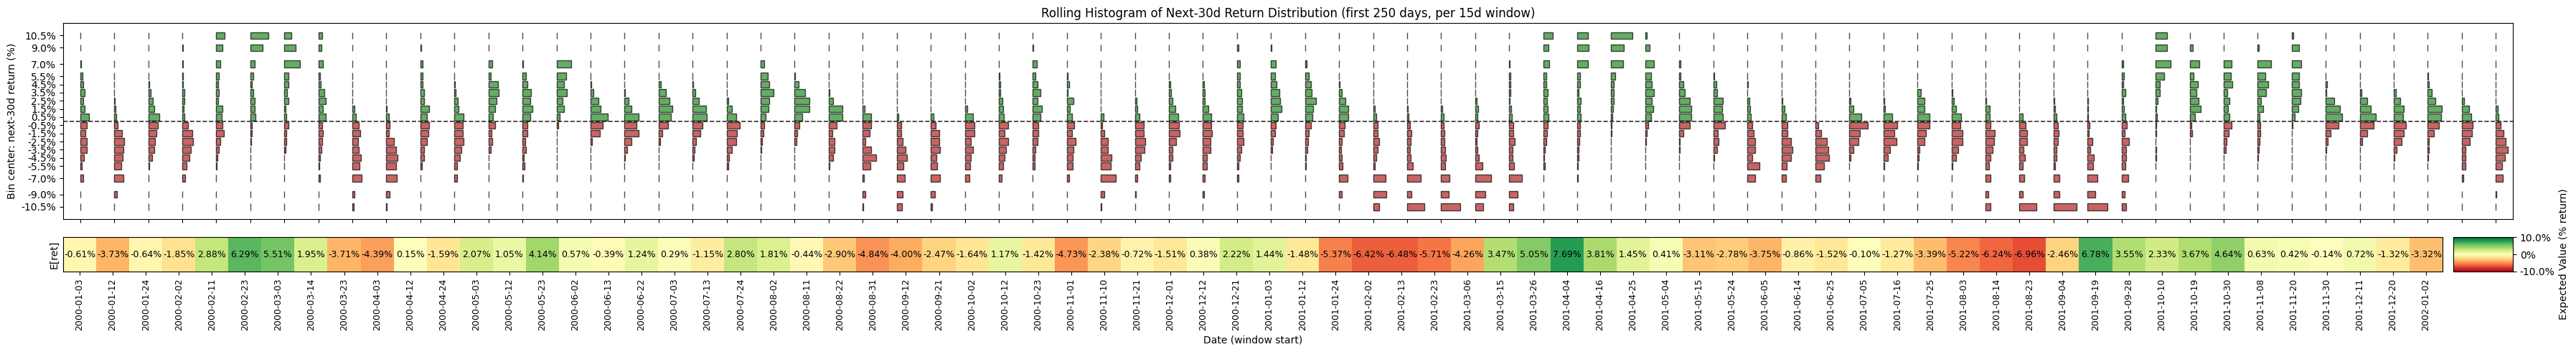

In [7]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

X_STEP = 7
FIRST_ROW_TO_GRAPH = 500
bin_edges = [float('-inf'),-0.10,-0.08,-0.06, -0.05, -0.04, -0.03, -0.02, -0.01, 0.0,
             0.01, 0.02, 0.03, 0.04, 0.05,0.06,0.08,0.10, float('inf')]
num_bins = len(bin_edges) - 1

# Calculate bin centers
bin_centers = []
for i in range(len(bin_edges)-1):
    if np.isinf(bin_edges[i]):
        left = bin_edges[i+1] - 0.01
    else:
        left = bin_edges[i]
    if np.isinf(bin_edges[i+1]):
        right = bin_edges[i] + 0.01
    else:
        right = bin_edges[i+1]
    bin_centers.append(0.5 * (left + right))

step = X_STEP
y_target_short = y_target_df.iloc[:FIRST_ROW_TO_GRAPH]
dates = y_target_short.index
window_dates = [str(dates[i].date()) for i in range(0, len(dates), step)]

histograms = []
expected_vals = []
for i in range(0, len(y_target_short), step):
    window = y_target_short.iloc[i:i+step]
    hist = window.mean(axis=0)
    histograms.append(hist.values)
    exp_val = np.dot(hist.values, bin_centers)
    expected_vals.append(exp_val)
histograms = np.array(histograms)
expected_vals = np.array(expected_vals)

num_windows = histograms.shape[0]
x = np.arange(num_windows)

fig, (ax1, ax2) = plt.subplots(
    2, 1, figsize=(max(12, num_windows//2), 5), 
    gridspec_kw={"height_ratios": [4, 0.7]}, sharex=True
)

# Histogram row (top)
colors = []
for c in bin_centers:
    if c < 0:
        colors.append('firebrick')
    elif c == 0:
        colors.append('gray')
    else:
        colors.append('forestgreen')

bar_height = (bin_centers[1] - bin_centers[0]) * 0.55
width_scale = 1.8

for i in range(num_windows):
    ax1.barh(
        y=bin_centers,
        width=histograms[i, :] * width_scale,
        left=i,
        height=bar_height,
        color=colors,
        alpha=0.7,
        edgecolor='k'
    )

ax1.set_ylabel('Bin center: next-30d return (%)')
ax1.set_title("Rolling Histogram of Next-30d Return Distribution (first 250 days, per 15d window)")
ax1.set_yticks(bin_centers)
ax1.set_yticklabels([f"{c*100:.1f}%" for c in bin_centers])
ax1.axhline(y=0, color='black', linestyle='--', linewidth=1.2, alpha=0.8, zorder=1)
ax1.set_xlim(-0.5, num_windows - 0.5)

# Expected value row (bottom)
# Set range for colormap (e.g., from -10% to +10%)
vmin, vmax = -0.1, 0.1
norm = mcolors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)
cmap = plt.cm.get_cmap('RdYlGn')  # Red-Yellow-Green

for i in range(num_windows):
    ev = expected_vals[i]
    color = cmap(norm(ev)) if not np.isnan(ev) else 'lightgray'
    rect = ax2.bar(i, 1, color=color, width=1.0, edgecolor='none')
    # Show value as a percent, if enough space
    if not np.isnan(ev):
        ax2.text(i, 0.5, f"{ev*100:.2f}%", va='center', ha='center', fontsize=9, color='black')

ax2.set_yticks([])
ax2.set_ylabel("E[ret]")
ax2.set_xlim(-0.5, num_windows - 0.5)
ax2.set_ylim(0, 1)
ax2.set_xticks(x)
ax2.set_xticklabels(window_dates, rotation=90, fontsize=9)
ax2.set_xlabel('Date (window start)')

# Add colorbar as legend for expected value
from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='2.5%', pad=0.15)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, cax=cax, orientation='vertical')
cbar.set_label('Expected Value (% return)')
cbar.set_ticks([vmin, 0, vmax])
cbar.set_ticklabels([f"{vmin*100:.1f}%", "0%", f"{vmax*100:.1f}%"])

plt.tight_layout()
plt.show()


In [8]:
import numpy as np
import pandas as pd
from scipy.stats import skew, kurtosis

# 1. Setup bin centers
bin_centers = []
for i in range(len(bin_edges)-1):
    if np.isinf(bin_edges[i]):
        left = bin_edges[i+1] - 0.01
    else:
        left = bin_edges[i]
    if np.isinf(bin_edges[i+1]):
        right = bin_edges[i] + 0.01
    else:
        right = bin_edges[i+1]
    bin_centers.append(0.5 * (left + right))
bin_centers = np.array(bin_centers)
bin_labels = [f'bin{i}' for i in range(len(bin_centers))]

# 2. Compute rolling moments
def ytarget_rolling_moments(y_bins, bin_centers, window):
    vals = y_bins.values
    index = y_bins.index
    means, medians, skews, kurts = [], [], [], []
    for i in range(len(y_bins)):
        start = max(0, i-window)
        arrs = vals[start:i]  # use only the prior days
        if arrs.shape[0] == 0:
            means.append(np.nan)
            medians.append(np.nan)
            skews.append(np.nan)
            kurts.append(np.nan)
            continue
        weighted_means = arrs @ bin_centers
        means.append(np.mean(weighted_means))
        # Weighted median
        def weighted_median(p):
            cdf = np.cumsum(p)
            return bin_centers[np.searchsorted(cdf, 0.5)]
        medians.append(np.median([weighted_median(p) for p in arrs]))
        # Skew and kurtosis using samples
        samples = [np.random.choice(bin_centers, p=(p/p.sum() if p.sum() > 0 else None), size=100) for p in arrs]
        all_samples = np.concatenate(samples) if len(samples) else np.array([np.nan])
        skews.append(skew(all_samples))
        kurts.append(kurtosis(all_samples))
    return pd.DataFrame({
        f'y_mean_prev{window}d': means,
        f'y_median_prev{window}d': medians,
        f'y_skew_prev{window}d': skews,
        f'y_kurtosis_prev{window}d': kurts,
    }, index=index)

# Compute and join
for window in [1, 3, 7]:
    moments = ytarget_rolling_moments(y_target_df, bin_centers, window)
    df = df.join(moments)
print(df.columns)
print(y_target_df)

Index(['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume', 'CPIAUCSL',
       'M2SL', 'DGS30', 'FEDFUNDS', 'GDPC1', 'UNRATE', 'DGS10', 'DGS2',
       'UMCSENT', 'y_mean_prev1d', 'y_median_prev1d', 'y_skew_prev1d',
       'y_kurtosis_prev1d', 'y_mean_prev3d', 'y_median_prev3d',
       'y_skew_prev3d', 'y_kurtosis_prev3d', 'y_mean_prev7d',
       'y_median_prev7d', 'y_skew_prev7d', 'y_kurtosis_prev7d'],
      dtype='object')
            bin0  bin1      bin2      bin3      bin4      bin5      bin6  \
2000-01-03   0.0   0.0  0.033333  0.033333  0.100000  0.233333  0.166667   
2000-01-04   0.0   0.0  0.000000  0.000000  0.000000  0.000000  0.033333   
2000-01-05   0.0   0.0  0.000000  0.000000  0.000000  0.000000  0.033333   
2000-01-06   0.0   0.0  0.000000  0.000000  0.000000  0.000000  0.000000   
2000-01-07   0.0   0.0  0.100000  0.033333  0.133333  0.233333  0.133333   
...          ...   ...       ...       ...       ...       ...       ...   
2025-05-16   NaN   NaN       NaN      

In [9]:
print(df.columns)
print(y_target_df)

Index(['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume', 'CPIAUCSL',
       'M2SL', 'DGS30', 'FEDFUNDS', 'GDPC1', 'UNRATE', 'DGS10', 'DGS2',
       'UMCSENT', 'y_mean_prev1d', 'y_median_prev1d', 'y_skew_prev1d',
       'y_kurtosis_prev1d', 'y_mean_prev3d', 'y_median_prev3d',
       'y_skew_prev3d', 'y_kurtosis_prev3d', 'y_mean_prev7d',
       'y_median_prev7d', 'y_skew_prev7d', 'y_kurtosis_prev7d'],
      dtype='object')
            bin0  bin1      bin2      bin3      bin4      bin5      bin6  \
2000-01-03   0.0   0.0  0.033333  0.033333  0.100000  0.233333  0.166667   
2000-01-04   0.0   0.0  0.000000  0.000000  0.000000  0.000000  0.033333   
2000-01-05   0.0   0.0  0.000000  0.000000  0.000000  0.000000  0.033333   
2000-01-06   0.0   0.0  0.000000  0.000000  0.000000  0.000000  0.000000   
2000-01-07   0.0   0.0  0.100000  0.033333  0.133333  0.233333  0.133333   
...          ...   ...       ...       ...       ...       ...       ...   
2025-05-16   NaN   NaN       NaN      

In [10]:
macro_cols = [
    "CPIAUCSL",
    "M2SL",
    "DGS30",
    "FEDFUNDS",
    "GDPC1",
    "UNRATE",
    "DGS10",
    "DGS2",
    "UMCSENT",
]

for macro in macro_cols:
    df[f"{macro}_diff_to_30d_ma"] = (df[macro] - df[macro].rolling(30, min_periods=1).mean())
    df[f"{macro}_diff_to_200d_ma"] = df[macro] - df[macro].rolling(200, min_periods=1).mean()
    df[f"{macro}_ratio_to_30d_ma"] = (df[macro] - df[macro].rolling(30, min_periods=1).mean())/df[macro]
    df[f"{macro}_ratio_to_200d_ma"] = (df[macro] - df[macro].rolling(200, min_periods=1).mean())/df[macro]


In [11]:
print(df.columns)
print(y_target_df.columns)

Index(['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume', 'CPIAUCSL',
       'M2SL', 'DGS30', 'FEDFUNDS', 'GDPC1', 'UNRATE', 'DGS10', 'DGS2',
       'UMCSENT', 'y_mean_prev1d', 'y_median_prev1d', 'y_skew_prev1d',
       'y_kurtosis_prev1d', 'y_mean_prev3d', 'y_median_prev3d',
       'y_skew_prev3d', 'y_kurtosis_prev3d', 'y_mean_prev7d',
       'y_median_prev7d', 'y_skew_prev7d', 'y_kurtosis_prev7d',
       'CPIAUCSL_diff_to_30d_ma', 'CPIAUCSL_diff_to_200d_ma',
       'CPIAUCSL_ratio_to_30d_ma', 'CPIAUCSL_ratio_to_200d_ma',
       'M2SL_diff_to_30d_ma', 'M2SL_diff_to_200d_ma', 'M2SL_ratio_to_30d_ma',
       'M2SL_ratio_to_200d_ma', 'DGS30_diff_to_30d_ma',
       'DGS30_diff_to_200d_ma', 'DGS30_ratio_to_30d_ma',
       'DGS30_ratio_to_200d_ma', 'FEDFUNDS_diff_to_30d_ma',
       'FEDFUNDS_diff_to_200d_ma', 'FEDFUNDS_ratio_to_30d_ma',
       'FEDFUNDS_ratio_to_200d_ma', 'GDPC1_diff_to_30d_ma',
       'GDPC1_diff_to_200d_ma', 'GDPC1_ratio_to_30d_ma',
       'GDPC1_ratio_to_200d_ma', 'UN

In [12]:
# Assuming df has columns: 'Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume'
import pandas as pd

# Typical windows
short_ma = 10
long_ma = 50

# Moving Averages
df['close_sma_10'] = df['Adj Close'].rolling(short_ma).mean()
df['close_sma_50'] = df['Adj Close'].rolling(long_ma).mean()
df['close_ema_10'] = df['Adj Close'].ewm(span=10, adjust=False).mean()
df['close_ema_50'] = df['Adj Close'].ewm(span=50, adjust=False).mean()

# Rate of Change and Momentum
df['roc_10'] = df['Adj Close'].pct_change(periods=10)
df['momentum_10'] = df['Adj Close'] - df['Adj Close'].shift(10)

# Volatility
df['close_rolling_std_10'] = df['Adj Close'].rolling(10).std()

print(df.dtypes)
# True Range and ATR
df['prev_close'] = df['Adj Close'].shift(1)
df['tr'] = df[['High', 'prev_close']].max(axis=1) - df[['Low', 'prev_close']].min(axis=1)
df['atr_14'] = df['tr'].rolling(14).mean()

# RSI (14)
delta = df['Adj Close'].diff()
gain = delta.clip(lower=0)
loss = -delta.clip(upper=0)
avg_gain = gain.rolling(14).mean()
avg_loss = loss.rolling(14).mean()
rs = avg_gain / (avg_loss + 1e-9)  # Prevent division by zero
df['rsi_14'] = 100 - (100 / (1 + rs))

# MACD (12/26), signal line (9)
ema12 = df['Adj Close'].ewm(span=12, adjust=False).mean()
ema26 = df['Adj Close'].ewm(span=26, adjust=False).mean()
df['macd'] = ema12 - ema26
df['macd_signal'] = df['macd'].ewm(span=9, adjust=False).mean()

# Bollinger Bands (20, 2 std)
df['bb_mid'] = df['Adj Close'].rolling(20).mean()
df['bb_std'] = df['Adj Close'].rolling(20).std()
df['bb_upper'] = df['bb_mid'] + 2*df['bb_std']
df['bb_lower'] = df['bb_mid'] - 2*df['bb_std']

# Volume z-score
df['volume_z_20'] = (df['Volume'] - df['Volume'].rolling(20).mean()) / df['Volume'].rolling(20).std()

# Drop helper columns if not needed
df = df.drop(columns=['prev_close', 'tr'], errors='ignore')


Adj Close               float64
Close                   float64
High                    float64
Low                     float64
Open                    float64
                         ...   
close_ema_10            float64
close_ema_50            float64
roc_10                  float64
momentum_10             float64
close_rolling_std_10    float64
Length: 70, dtype: object


In [13]:
print(df.columns)
print(df.isna().sum())
print(y_target_df.columns)
print(y_target_df.isna().sum())


# Merge on date index
merged = df.join(y_target_df, how='inner')

# Drop rows with any NaN
merged = merged.dropna()

# Drop the original columns you specified
drop_cols = [
    'Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume', 'CPIAUCSL',
    'M2SL', 'DGS30', 'FEDFUNDS', 'GDPC1', 'UNRATE', 'DGS10', 'DGS2',
    'UMCSENT'
]
# Drop only if present
merged = merged.drop(columns=[c for c in drop_cols if c in merged.columns])

print("Final merged shape:", merged.shape)
print( merged.columns)
print( merged.isna().sum())

Index(['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume', 'CPIAUCSL',
       'M2SL', 'DGS30', 'FEDFUNDS', 'GDPC1', 'UNRATE', 'DGS10', 'DGS2',
       'UMCSENT', 'y_mean_prev1d', 'y_median_prev1d', 'y_skew_prev1d',
       'y_kurtosis_prev1d', 'y_mean_prev3d', 'y_median_prev3d',
       'y_skew_prev3d', 'y_kurtosis_prev3d', 'y_mean_prev7d',
       'y_median_prev7d', 'y_skew_prev7d', 'y_kurtosis_prev7d',
       'CPIAUCSL_diff_to_30d_ma', 'CPIAUCSL_diff_to_200d_ma',
       'CPIAUCSL_ratio_to_30d_ma', 'CPIAUCSL_ratio_to_200d_ma',
       'M2SL_diff_to_30d_ma', 'M2SL_diff_to_200d_ma', 'M2SL_ratio_to_30d_ma',
       'M2SL_ratio_to_200d_ma', 'DGS30_diff_to_30d_ma',
       'DGS30_diff_to_200d_ma', 'DGS30_ratio_to_30d_ma',
       'DGS30_ratio_to_200d_ma', 'FEDFUNDS_diff_to_30d_ma',
       'FEDFUNDS_diff_to_200d_ma', 'FEDFUNDS_ratio_to_30d_ma',
       'FEDFUNDS_ratio_to_200d_ma', 'GDPC1_diff_to_30d_ma',
       'GDPC1_diff_to_200d_ma', 'GDPC1_ratio_to_30d_ma',
       'GDPC1_ratio_to_200d_ma', 'UN

In [14]:
# Assumption: normalized distribution of returns in next 30d
# Approach: Frequency vector per bin aggregated into histogram
# Loss function for prob vs prob: KL Divergence, Jensen-ShannonCross-Entropy, Earth Mover’s Distance, L2/L1
# y target: a vector of length num_bins e.g. [0.05, 0.10, 0.20, 0.40, 0.25] with bin0: >5%, bin1: 4-5%...

import numpy as np
import sklearn.metrics
from scipy.stats import entropy
from scipy.spatial.distance import jensenshannon
from scipy.stats import wasserstein_distance

# Probability-based metrics
def kl_divergence(y_true, y_pred):
    # Add small epsilon to avoid log(0)
    eps = 1e-9
    y_true = np.clip(y_true, eps, 1)
    y_pred = np.clip(y_pred, eps, 1)
    return np.mean([entropy(y_t, y_p) for y_t, y_p in zip(y_true, y_pred)])

def js_divergence(y_true, y_pred):
    # Jensen-Shannon is symmetric and bounded
    return np.mean([jensenshannon(y_t, y_p) ** 2 for y_t, y_p in zip(y_true, y_pred)])  # squared = actual JS div

def cross_entropy_loss(y_true, y_pred):
    # Add small epsilon to avoid log(0)
    eps = 1e-9
    y_pred = np.clip(y_pred, eps, 1)
    return -np.mean([np.sum(y_t * np.log(y_p)) for y_t, y_p in zip(y_true, y_pred)])

def l2_loss(y_true, y_pred):
    return np.mean([np.sum((y_t - y_p) ** 2) for y_t, y_p in zip(y_true, y_pred)])

def l1_loss(y_true, y_pred):
    return np.mean([np.sum(np.abs(y_t - y_p)) for y_t, y_p in zip(y_true, y_pred)])

def earth_movers_distance(y_true, y_pred, bin_centers=None):
    # This expects true and pred to be [n_samples, n_bins], and bin_centers to be [n_bins]
    if bin_centers is None:
        raise ValueError("Must provide bin_centers for Earth Mover's Distance")
    # Compute EMD for each pair
    emds = []
    for yt, yp in zip(y_true, y_pred):
        # Convert prob dist to sample dist over bin centers
        emds.append(wasserstein_distance(bin_centers, bin_centers, u_weights=yt, v_weights=yp))
    return np.mean(emds)

# Map of string -> (metric name, metric function)
metric_lookup = {
    "kl_divergence": ("KL Divergence", kl_divergence),
    "js_divergence": ("Jensen-Shannon Divergence", js_divergence),
    "cross_entropy": ("Cross-Entropy", cross_entropy_loss),
    "l2": ("L2 Loss", l2_loss),
    "l1": ("L1 Loss", l1_loss),
    # EMD needs bin_centers, so we handle that separately
}

perf_eval_metric = "kl_divergence"  # Or "js_divergence", "cross_entropy", "l2", "l1"

if perf_eval_metric not in metric_lookup:
    raise ValueError(f"Unsupported metric: {perf_eval_metric}")

eval_metric_name, eval_metric_fn = metric_lookup[perf_eval_metric]
print(f"✅ Evaluation metric set to: {eval_metric_name}")

# Example of usage:
# Suppose y_true and y_pred are both (n_samples, n_bins)
# y_true = merged[[f'bin{i}' for i in range(num_bins)]].values
# y_pred = model.predict(X)  # shape: (n_samples, n_bins)

# metric_value = eval_metric_fn(y_true, y_pred)


✅ Evaluation metric set to: KL Divergence


In [15]:
# === Domain knowledge ===
# Any semantic/description of features?
# PassengerId - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.
# HomePlanet - The planet the passenger departed from, typically their planet of permanent residence.
# CryoSleep - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
# Cabin - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
# Destination - The planet the passenger will be debarking to.
# Age - The age of the passenger.
# VIP - Whether the passenger has paid for special VIP service during the voyage.
# RoomService, FoodCourt, ShoppingMall, Spa, VRDeck - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
# Name - The first and last names of the passenger.
# Transported - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.

In [16]:
# from utils.eda import eda_vis
# # === prelim EDA on raw dataset ===
# eda_vis(X, y, task_type)
# reload_utils()
# from utils.eda import feature_eda_vis
# # === deep EDA for features on ETL-applied dataset ===
# feature_eda_vis(X, y, task_type)

In [ ]:
# import matplotlib.pyplot as plt
# import seaborn as sns
# import pandas as pd
# import numpy as np
# from scipy import stats
# from statsmodels.stats.proportion import proportion_confint

# # Assume X and y are pandas DataFrames/Series as described by the user.
# # For demonstration, let's create some sample data if X and y are not defined
# # (Remove or comment this out if you have your actual X and y)
# if 'X' not in locals() or 'y' not in locals():
#     print("Generating sample X and y for demonstration purposes...")
#     n_samples = 200
#     X_data = {
#         'HomePlanet': np.random.choice(['Earth', 'Europa', 'Mars', 'PlanetX', 'PlanetY'], size=n_samples), # Added more categories
#         'CryoSleep': np.random.choice([True, False, np.nan], size=n_samples, p=[0.25, 0.7, 0.05]), # Added NaNs
#         'Age': np.random.normal(loc=30, scale=10, size=n_samples).clip(0, 80),
#         'RoomService': np.random.exponential(scale=100, size=n_samples).clip(0, 2000) * np.random.choice([0,1, np.nan], size=n_samples, p=[0.35,0.55, 0.1]), # Some zeros and NaNs
#         'VIP': np.random.choice([True, False, np.nan], size=n_samples, p=[0.05, 0.85, 0.1]) # With NaNs
#     }
#     X = pd.DataFrame(X_data)
#     X['Age'] = X['Age'].astype(float).fillna(X['Age'].median()).astype(int) # Handle potential NaNs from clip then fill
#     X['RoomService'] = X['RoomService'].astype(float)
    
#     # Simulate some dependency for y
#     y_score = X['Age'] * -0.1 + X['RoomService'].fillna(0) * 0.01 + \
#               (X['HomePlanet'] == 'Europa').astype(int) * 20 + \
#               X['CryoSleep'].fillna(False).astype(int) * 30 # Handle NaNs in CryoSleep for scoring
#     y_prob = 1 / (1 + np.exp(- (y_score - y_score.mean()) / y_score.std() )) # Sigmoid
#     y = pd.Series(np.random.binomial(1, y_prob, size=n_samples).astype(bool), name='Transported')


# # --- Data Preparation ---
# y_named = y.copy()
# if not hasattr(y_named, 'name') or y_named.name is None:
#     y_named.name = 'Transported' # Default name if y has no name

# df_combined = X.copy()
# df_combined['Transported_numeric'] = y_named.astype(int)

# CATEGORICAL_THRESHOLD = 20 
# palette = {0: 'skyblue', 1: 'salmon'} 
# legend_labels = {0: 'Not Transported', 1: 'Transported'}
# feature_columns = X.columns

# # --- Main Loop for Plotting ---
# for feature_col in feature_columns:
#     print(f"--- Analyzing Feature: {feature_col} ---")
    
#     fig, axes = plt.subplots(2, 3, figsize=(22, 13)) # Adjusted figsize slightly for better label spacing
#     fig.suptitle(f'Comprehensive Analysis: {feature_col} | Target: {y_named.name}', fontsize=18, y=0.99) # Adjusted y for suptitle
    
#     # --- Row 1: Distribution Visualizations ---
#     ax_1_1 = axes[0, 0]
#     try:
#         plot_data_1_1 = df_combined[[feature_col, 'Transported_numeric']].dropna(subset=[feature_col])
#         if not plot_data_1_1.empty and plot_data_1_1[feature_col].nunique() > 0 :
#             sns.stripplot(data=plot_data_1_1, x=feature_col, y='Transported_numeric', hue='Transported_numeric',
#                           jitter=0.25, dodge=True, ax=ax_1_1, palette=palette, legend=False, alpha=0.6)
#             ax_1_1.set_title('Point Distribution by Target')
#             ax_1_1.set_ylabel(f'{y_named.name} (0=F, 1=T)')
#             ax_1_1.set_yticks([0, 1])
#             ax_1_1.set_yticklabels(['False', 'True'])
#             ax_1_1.set_xlabel(feature_col)
#             handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=palette[i], markersize=10) for i in palette]
#             ax_1_1.legend(handles, [legend_labels[i] for i in palette], title=y_named.name, loc='best')
            
#             # Rotate x-axis labels if needed
#             if plot_data_1_1[feature_col].nunique() > 5 and plot_data_1_1[feature_col].dtype == 'object': # More categories
#                  ax_1_1.tick_params(axis='x', rotation=45, labelbottom=True)
#                  plt.setp(ax_1_1.get_xticklabels(), ha="right", rotation_mode="anchor")
#             elif plot_data_1_1[feature_col].nunique() > 10 and plot_data_1_1[feature_col].dtype != 'object': # Numerical with many ticks
#                  ax_1_1.tick_params(axis='x', rotation=30, labelbottom=True)
#                  plt.setp(ax_1_1.get_xticklabels(), ha="right", rotation_mode="anchor")
#             else: # Fewer categories or numerical, no rotation or default handling
#                  ax_1_1.tick_params(axis='x', labelbottom=True)

#         else:
#             ax_1_1.text(0.5, 0.5, "No data or no variance\nafter NaN drop", ha='center', va='center', transform=ax_1_1.transAxes)
#             ax_1_1.set_title('Point Distribution (No Data)')
#     except Exception as e:
#         ax_1_1.set_title('Point Distribution (Error)')
#         ax_1_1.text(0.5, 0.5, f"Plot failed: {e}", ha='center', va='center', transform=ax_1_1.transAxes, wrap=True)
#         print(f"  Error in Plot 1.1 for {feature_col}: {e}")

#     ax_1_2 = axes[0, 1]
#     try:
#         plot_data_1_2 = df_combined[[feature_col, 'Transported_numeric']].dropna(subset=[feature_col])
#         if not plot_data_1_2.empty and plot_data_1_2[feature_col].nunique() > 0:
#             sns.histplot(data=plot_data_1_2, x=feature_col, hue='Transported_numeric', 
#                          multiple='layer', kde=False, ax=ax_1_2, palette=palette, 
#                          stat="density", common_norm=False, alpha=0.6, legend=True)
#             ax_1_2.set_title('Normalized Histogram by Target')
#             ax_1_2.set_xlabel(feature_col)
#             handles_hist, labels_hist = ax_1_2.get_legend_handles_labels()
#             try: 
#                 labels_hist_descriptive = [legend_labels[int(float(l))] for l in labels_hist]
#                 ax_1_2.legend(handles_hist, labels_hist_descriptive, title=y_named.name)
#             except (ValueError, KeyError): 
#                  ax_1_2.legend(title=y_named.name)
#         else:
#             ax_1_2.text(0.5, 0.5, "No data or no variance\nafter NaN drop", ha='center', va='center', transform=ax_1_2.transAxes)
#             ax_1_2.set_title('Histogram (No Data)')
#     except Exception as e:
#         ax_1_2.set_title('Histogram (Error)')
#         ax_1_2.text(0.5, 0.5, f"Plot failed: {e}", ha='center', va='center', transform=ax_1_2.transAxes, wrap=True)
#         print(f"  Error in Plot 1.2 for {feature_col}: {e}")

#     ax_1_3 = axes[0, 2]
#     try:
#         temp_df_combined = df_combined.dropna(subset=[feature_col]) 
#         if not temp_df_combined.empty and temp_df_combined[feature_col].nunique() > 0:
#             is_categorical_like = temp_df_combined[feature_col].dtype == 'object' or \
#                                   temp_df_combined[feature_col].nunique() < CATEGORICAL_THRESHOLD
            
#             target_0_data = temp_df_combined[temp_df_combined['Transported_numeric'] == 0][feature_col]
#             target_1_data = temp_df_combined[temp_df_combined['Transported_numeric'] == 1][feature_col]

#             if not target_0_data.empty and not target_1_data.empty:
#                 if is_categorical_like:
#                     props_0 = target_0_data.value_counts(normalize=True)
#                     props_1 = target_1_data.value_counts(normalize=True)
#                     all_categories = sorted(list(set(props_0.index) | set(props_1.index)))
#                     props_0 = props_0.reindex(all_categories, fill_value=0)
#                     props_1 = props_1.reindex(all_categories, fill_value=0)
#                     diff_props = props_1 - props_0
#                     diff_props.plot(kind='bar', ax=ax_1_3, color=['tomato' if x < 0 else 'mediumseagreen' for x in diff_props.values]) # Removed rot here
#                     ax_1_3.tick_params(axis='x', rotation=45) # Apply rotation
#                     plt.setp(ax_1_3.get_xticklabels(), ha='right', rotation_mode='anchor') # Ensure alignment
#                     ax_1_3.set_ylabel('Prop(Y=1) - Prop(Y=0)')
#                 else: 
#                     min_val = min(target_0_data.min(), target_1_data.min())
#                     max_val = max(target_0_data.max(), target_1_data.max())
#                     if pd.isna(min_val) or pd.isna(max_val) or min_val == max_val: # Handle NaN or single value case
#                         bins = np.array([temp_df_combined[feature_col].min() - 0.5, temp_df_combined[feature_col].max() + 0.5]) if temp_df_combined[feature_col].nunique() > 0 else np.array([0,1])
#                     else: 
#                         bins = np.linspace(min_val, max_val, 11)
#                     hist_0, _ = np.histogram(target_0_data.dropna(), bins=bins, density=True) # dropna within histogram
#                     hist_1, _ = np.histogram(target_1_data.dropna(), bins=bins, density=True) # dropna within histogram
#                     diff_hist = hist_1 - hist_0
#                     bin_centers = (bins[:-1] + bins[1:]) / 2
#                     bar_width = bins[1] - bins[0] if len(bins) > 1 else 1
#                     ax_1_3.bar(bin_centers, diff_hist, width=bar_width * 0.9, 
#                                 color=['tomato' if x < 0 else 'mediumseagreen' for x in diff_hist])
#                     ax_1_3.set_ylabel('Density(Y=1) - Density(Y=0)')
#                 ax_1_3.axhline(0, color='black', lw=0.8, linestyle='--')
#                 ax_1_3.set_title('Outcome Difference by Feature Value')
#                 ax_1_3.set_xlabel(feature_col)
#             else:
#                 ax_1_3.text(0.5, 0.5, "Not enough data in one/both target groups", ha='center', va='center', transform=ax_1_3.transAxes)
#                 ax_1_3.set_title('Outcome Difference (Not enough data)')
#         else:
#             ax_1_3.text(0.5, 0.5, "No data or no variance\nafter NaN drop", ha='center', va='center', transform=ax_1_3.transAxes)
#             ax_1_3.set_title('Outcome Difference (No Data)')
#     except Exception as e:
#         ax_1_3.set_title('Outcome Difference (Error)')
#         ax_1_3.text(0.5, 0.5, f"Plot failed: {e}", ha='center', va='center', transform=ax_1_3.transAxes, wrap=True)
#         print(f"  Error in Plot 1.3 for {feature_col}: {e}")

#     # --- Row 2: Statistical Significance ---
#     ax_2_1 = axes[1, 0] 
#     ax_2_2 = axes[1, 1] 
#     ax_2_3 = axes[1, 2] 

#     for ax_text in [ax_2_2, ax_2_3]:
#         ax_text.clear()
#         ax_text.axis('off')

#     current_feature_data = df_combined[[feature_col, 'Transported_numeric']].dropna(subset=[feature_col])
#     if current_feature_data.empty or current_feature_data[feature_col].nunique() == 0: # Also check for no variance
#         ax_2_1.text(0.5, 0.5, "No data or no variance\nfor stats after NaN drop", ha='center', va='center', transform=ax_2_1.transAxes)
#         ax_2_1.set_title('Stats (No Data)')
#         ax_2_2.text(0.05, 0.9, "No data or no variance for stats after NaN drop.", fontsize=9, va='top', wrap=True)
#         ax_2_3.text(0.05, 0.9, "No data or no variance for stats after NaN drop.", fontsize=9, va='top', wrap=True)
#         fig.subplots_adjust(hspace=0.6, wspace=0.35, top=0.93, bottom=0.08, left=0.05, right=0.97)
#         plt.show()
#         continue 

#     is_categorical_feature = current_feature_data[feature_col].dtype == 'object' or \
#                              current_feature_data[feature_col].nunique() < CATEGORICAL_THRESHOLD
    
#     stats_summary_text = ""
#     interpretation_text = ""

#     if is_categorical_feature:
#         ax_2_1.set_title(f'Proportion Transported by {feature_col}\n(with 95% CIs)')
#         # Ensure feature_col is treated as string for crosstab if it's not already object (e.g. boolean, int categories)
#         contingency_table = pd.crosstab(current_feature_data[feature_col].astype(str), current_feature_data['Transported_numeric'])
        
#         if contingency_table.shape[0] < 1 or contingency_table.shape[1] < 2 : # Need at least 1 category and 2 outcome classes
#             stats_summary_text += "Chi-squared test not applicable (table too small or one outcome class missing).\n"
#             ax_2_1.text(0.5,0.5, "Too few categories or\noutcomes for plot/test", ha='center', va='center', transform=ax_2_1.transAxes)
#         elif contingency_table.shape[0] < 2: # Need at least 2 categories for chi2
#              stats_summary_text += "Chi-squared test not applicable (needs at least 2 categories).\n"
#              ax_2_1.text(0.5,0.5, "Needs at least 2 categories for Chi2 test", ha='center', va='center', transform=ax_2_1.transAxes)
#         else:
#             chi2, p_chi2, dof, expected = stats.chi2_contingency(contingency_table)
#             stats_summary_text += f"Chi-squared Test of Independence:\n"
#             stats_summary_text += f"  Chi2 Stat: {chi2:.2f}, P-value: {p_chi2:.3g}\n  DOF: {dof}\n"
#             interpretation_text += f"P-value ({p_chi2:.3g}) for Chi-squared test: "
#             interpretation_text += "Suggests " + ("a significant" if p_chi2 < 0.05 else "no significant") + \
#                                    f" association between {feature_col} and {y_named.name}.\n\n"

#             categories = contingency_table.index
#             proportions_transported = []
#             ci_lows = []
#             ci_highs = []
            
#             for cat in categories:
#                 count_transported = contingency_table.loc[cat, 1] if 1 in contingency_table.columns else 0
#                 count_not_transported = contingency_table.loc[cat, 0] if 0 in contingency_table.columns else 0
#                 n_obs_cat = count_transported + count_not_transported
#                 if n_obs_cat > 0:
#                     prop = count_transported / n_obs_cat
#                     low, high = proportion_confint(count_transported, n_obs_cat, method='wilson')
#                     proportions_transported.append(prop)
#                     ci_lows.append(low)
#                     ci_highs.append(high)
#                 else: 
#                     proportions_transported.append(0)
#                     ci_lows.append(0)
#                     ci_highs.append(0)

#             prop_df = pd.DataFrame({
#                 'category': categories, # Already strings due to .astype(str) in crosstab
#                 'proportion_transported': proportions_transported,
#                 'ci_low': ci_lows,
#                 'ci_high': ci_highs
#             })
            
#             ax_2_1.bar(prop_df['category'], prop_df['proportion_transported'], 
#                        yerr=[prop_df['proportion_transported'] - prop_df['ci_low'], prop_df['ci_high'] - prop_df['proportion_transported']],
#                        capsize=5, color='mediumseagreen', alpha=0.7)
#             ax_2_1.set_ylabel(f'Proportion {y_named.name}')
#             ax_2_1.tick_params(axis='x', rotation=45) # Corrected: Apply rotation
#             plt.setp(ax_2_1.get_xticklabels(), ha='right', rotation_mode='anchor') # Corrected: Ensure alignment
#             ax_2_1.axhline(current_feature_data['Transported_numeric'].mean(), color='grey', linestyle='--', label='Overall Mean')
#             if not prop_df.empty: # Only add legend if there's data to plot
#                 ax_2_1.legend(loc='best')

#             interpretation_text += "Error bars on plot show 95% CIs for proportion transported. "
#             interpretation_text += "If CIs for different categories don't overlap much, "
#             interpretation_text += "it suggests a significant difference in transport rates.\n"

#     else: # Numerical feature
#         group0 = current_feature_data[current_feature_data['Transported_numeric'] == 0][feature_col].dropna() # Ensure NaNs are out for tests
#         group1 = current_feature_data[current_feature_data['Transported_numeric'] == 1][feature_col].dropna() # Ensure NaNs are out for tests

#         ax_2_1.set_title(f'{feature_col} Distribution by Target')
#         # For boxplot, ensure data passed has NaNs handled if seaborn version is older
#         sns.boxplot(x='Transported_numeric', y=feature_col, data=current_feature_data.dropna(subset=[feature_col]), 
#                     ax=ax_2_1, palette=palette, hue='Transported_numeric', legend=False)
#         ax_2_1.set_xticklabels([legend_labels[0], legend_labels[1]])
#         ax_2_1.set_xlabel(y_named.name)

#         stats_summary_text += "Normality (Shapiro-Wilk):\n"
#         norm_p0, norm_p1 = -1.0, -1.0 # Initialize as float
#         if len(group0) >=3 : 
#             shapiro_stat0, norm_p0 = stats.shapiro(group0)
#             stats_summary_text += f"  Group 0 (Not Transported): p={norm_p0:.3g}\n"
#         else: stats_summary_text += "  Group 0: Too few samples for normality test.\n"
#         if len(group1) >=3 :
#             shapiro_stat1, norm_p1 = stats.shapiro(group1)
#             stats_summary_text += f"  Group 1 (Transported): p={norm_p1:.3g}\n"
#         else: stats_summary_text += "  Group 1: Too few samples for normality test.\n"
        
#         # Default to Mann-Whitney U if any group has < 3 samples for normality, or if normality fails
#         use_ttest = (norm_p0 > 0.05 or len(group0) < 3) and \
#                     (norm_p1 > 0.05 or len(group1) < 3)

#         if use_ttest and len(group0)>1 and len(group1)>1:
#             levene_stat, levene_p = stats.levene(group0, group1)
#             stats_summary_text += f"Homogeneity of Variances (Levene's test): p={levene_p:.3g}\n"
#             equal_var = levene_p > 0.05

#             t_stat, p_ttest = stats.ttest_ind(group0, group1, equal_var=equal_var) # nan_policy='omit' is default in newer scipy
#             stats_summary_text += f"Independent T-test (equal_var={equal_var}):\n"
#             stats_summary_text += f"  T-statistic: {t_stat:.2f}, P-value: {p_ttest:.3g}\n"
#             interpretation_text += f"P-value ({p_ttest:.3g}) from t-test: "
#             interpretation_text += "Suggests " + ("a significant" if p_ttest < 0.05 else "no significant") + \
#                                    f" difference in mean {feature_col} between groups.\n"
#             ax_2_1.text(0.5, 0.95, f"T-test p-value: {p_ttest:.3g}", ha='center', va='top', transform=ax_2_1.transAxes, fontsize=9, color='red', bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

#         elif len(group0)>0 and len(group1)>0: 
#             try:
#                 u_stat, p_mannwhitney = stats.mannwhitneyu(group0, group1, alternative='two-sided') # nan_policy='omit' is default
#                 stats_summary_text += f"Mann-Whitney U Test:\n"
#                 stats_summary_text += f"  U-statistic: {u_stat:.0f}, P-value: {p_mannwhitney:.3g}\n"
#                 interpretation_text += f"P-value ({p_mannwhitney:.3g}) from Mann-Whitney U test: "
#                 interpretation_text += "Suggests " + ("a significant" if p_mannwhitney < 0.05 else "no significant") + \
#                                    f" difference in distributions of {feature_col} between groups.\n"
#                 ax_2_1.text(0.5, 0.95, f"Mann-Whitney p: {p_mannwhitney:.3g}", ha='center', va='top', transform=ax_2_1.transAxes, fontsize=9, color='red', bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))
#             except ValueError as e_mw: 
#                  stats_summary_text += f"Mann-Whitney U Test: Error - {e_mw}\n"
#                  interpretation_text += "Mann-Whitney U test could not be performed (e.g., identical data in groups).\n"
#         else:
#             stats_summary_text += "Not enough data in one or both groups for numerical tests.\n"
#             interpretation_text += "Not enough data to compare groups statistically.\n"

#     interpretation_text += "\nBayesian Perspective:\nA Bayesian approach could provide posterior distributions for parameters "
#     interpretation_text += "(e.g., difference in means/proportions). This offers a richer view of uncertainty "
#     interpretation_text += "and allows direct probability statements about the effect size, rather than just a p-value."

#     ax_2_2.text(0.01, 0.98, stats_summary_text, fontsize=8, va='top', ha='left', wrap=True, family='monospace') # Reduced font size
#     ax_2_2.set_title("Statistical Test Details", fontsize=10)
    
#     ax_2_3.text(0.01, 0.98, interpretation_text, fontsize=8, va='top', ha='left', wrap=True) # Reduced font size
#     ax_2_3.set_title("Interpretation & Bayesian Note", fontsize=10)

#     fig.subplots_adjust(hspace=0.7, wspace=0.4, top=0.93, bottom=0.12, left=0.06, right=0.97) # Adjusted spacing
#     plt.show()

# print("--- Finished generating all plots. ---")


In [17]:
import pandas as pd

# If not already defined, here are your bin labels:
num_bins = 18
bin_labels = [f'bin{i}' for i in range(num_bins)]

# Extract X and y from merged
X = merged.drop(columns=bin_labels)
y = merged[bin_labels]

print("X shape:", X.shape)
print("y shape:", y.shape)
print("Sample X columns:", X.shape)
print("Sample y (first row):", y.shape)


X shape: (6261, 64)
y shape: (6261, 18)
Sample X columns: (6261, 64)
Sample y (first row): (6261, 18)


In [18]:
task_type = "prob_vector"

In [19]:
reload_utils()
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from utils.train import train_sklearn_model, train_nn_model, log_model_artifact, log_final_metrics, evaluate_model
# Import XGBoost if available
try:
    from xgboost import XGBRegressor
    xgboost_available = True
except ImportError:
    xgboost_available = False
    print("XGBoost not installed! Install with `pip install xgboost` to use XGBRegressor.")

# --- 1. Split data into train/val (80%/20%, no shuffle for time series)
X = merged.drop(columns=bin_labels)
y = merged[bin_labels]

test_size = 0.2
split_index = int(len(X) * (1 - test_size))
X_train, X_val = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_val = y.iloc[:split_index], y.iloc[split_index:]

print(f"Train shape: {X_train.shape}, Validation shape: {X_val.shape}")

# --- 2. Random Forest Regressor (multioutput)
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
trained_rf, y_pred_rf = train_sklearn_model(
    rf_model, X_train, y_train, X_val, y_val, task_type="prob_vector"
)

# Ensure valid probabilities
y_pred_rf = np.clip(y_pred_rf, 0, None)
y_pred_rf = y_pred_rf / (y_pred_rf.sum(axis=1, keepdims=True) + 1e-9)

print("Random Forest y_pred_rf shape:", y_pred_rf.shape)

# --- 3. XGBoost Regressor (multioutput)
if xgboost_available:
    xgb_model = XGBRegressor(n_estimators=100, random_state=42, n_jobs=-1, tree_method="hist")
    trained_xgb, y_pred_xgb = train_sklearn_model(
        xgb_model, X_train, y_train, X_val, y_val, task_type="prob_vector"
    )
    y_pred_xgb = np.clip(y_pred_xgb, 0, None)
    y_pred_xgb = y_pred_xgb / (y_pred_xgb.sum(axis=1, keepdims=True) + 1e-9)
    print("XGBoost y_pred_xgb shape:", y_pred_xgb.shape)
else:
    y_pred_xgb = None

# --- 4. Save predictions for later
np.save("y_pred_rf.npy", y_pred_rf)
if y_pred_xgb is not None:
    np.save("y_pred_xgb.npy", y_pred_xgb)
y_val.to_numpy().dump("y_val.npy")

print("Predictions saved! Ready for evaluation.")


🔁 Reloaded ohlc_stock.etl_chain, utils.etl, utils.eda, utils.eval, utils.submission
Train shape: (5008, 64), Validation shape: (1253, 64)
Random Forest y_pred_rf shape: (1253, 18)
XGBoost y_pred_xgb shape: (1253, 18)
Predictions saved! Ready for evaluation.


/tmp/ipykernel_46288/2848264053.py:114: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('YlOrRd')


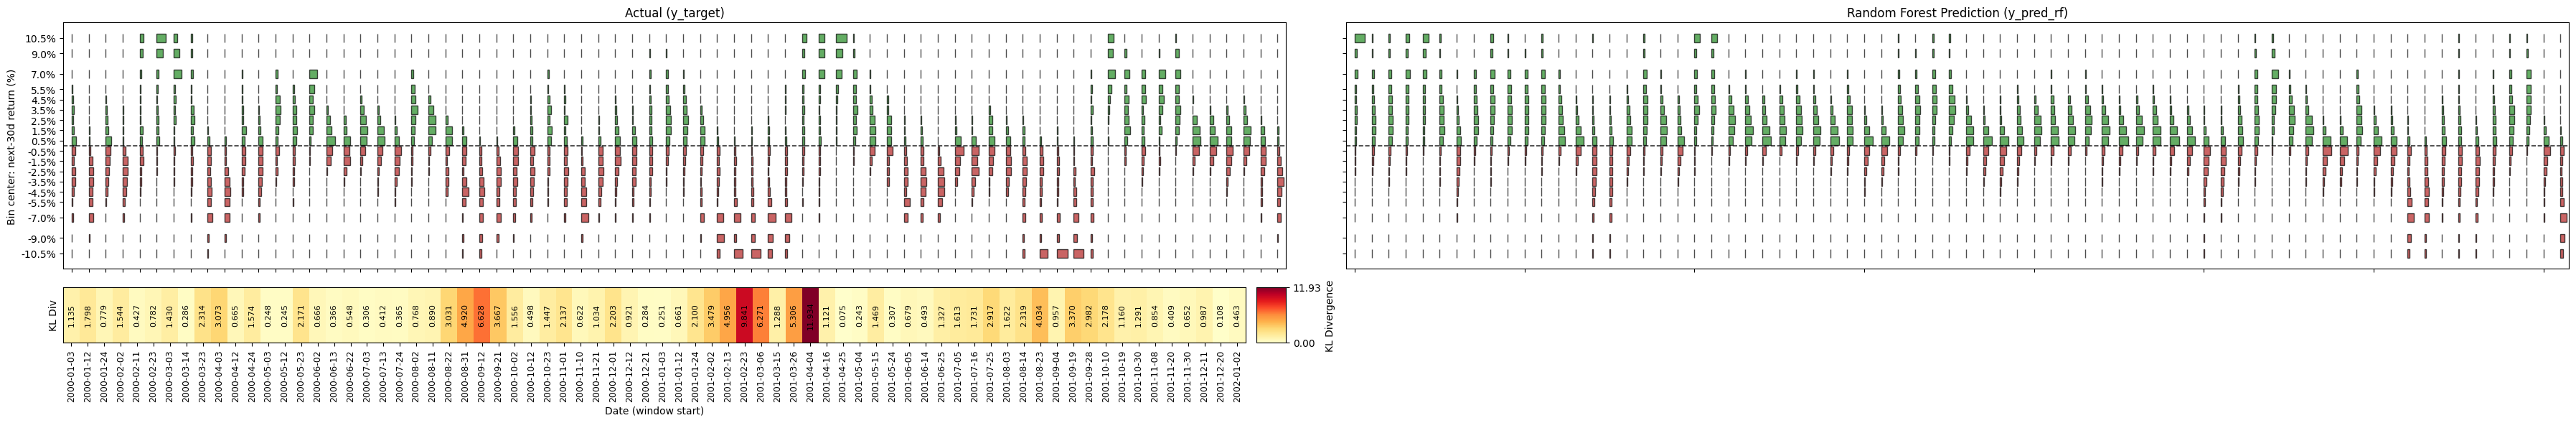

In [28]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
from scipy.stats import entropy

X_STEP = 7
FIRST_ROW_TO_GRAPH = 500
bin_edges = [float('-inf'),-0.10,-0.08,-0.06, -0.05, -0.04, -0.03, -0.02, -0.01, 0.0,
             0.01, 0.02, 0.03, 0.04, 0.05,0.06,0.08,0.10, float('inf')]
num_bins = len(bin_edges) - 1

# Bin centers
bin_centers = []
for i in range(len(bin_edges)-1):
    if np.isinf(bin_edges[i]):
        left = bin_edges[i+1] - 0.01
    else:
        left = bin_edges[i]
    if np.isinf(bin_edges[i+1]):
        right = bin_edges[i] + 0.01
    else:
        right = bin_edges[i+1]
    bin_centers.append(0.5 * (left + right))

# Actual (y_target)
step = X_STEP
y_target_short = y_target_df.iloc[:FIRST_ROW_TO_GRAPH]
dates = y_target_short.index
window_dates = [str(dates[i].date()) for i in range(0, len(dates), step)]
histograms_true = []
for i in range(0, len(y_target_short), step):
    window = y_target_short.iloc[i:i+step]
    hist = window.mean(axis=0)
    histograms_true.append(hist.values)
histograms_true = np.array(histograms_true)

# RF predicted
if isinstance(y_pred_rf, str):  # if it's a filename
    y_pred_rf = np.load(y_pred_rf, allow_pickle=True)
y_pred_rf_short = y_pred_rf[:FIRST_ROW_TO_GRAPH]
histograms_rf = []
for i in range(0, len(y_pred_rf_short), step):
    hist = y_pred_rf_short[i:i+step].mean(axis=0)
    histograms_rf.append(hist)
histograms_rf = np.array(histograms_rf)

num_windows = histograms_true.shape[0]
x = np.arange(num_windows)

# KL divergence per window
def safe_entropy(p, q):
    eps = 1e-9
    p = np.clip(p, eps, 1)
    q = np.clip(q, eps, 1)
    return entropy(p, q)

kl_values = np.array([safe_entropy(histograms_true[i], histograms_rf[i]) for i in range(num_windows)])

# -- Plot --
fig, axes = plt.subplots(
    2, 2, figsize=(max(14, num_windows//2), 6),
    gridspec_kw={"height_ratios": [4, 0.9]},
    sharex='col'
)

bar_height = (bin_centers[1] - bin_centers[0]) * 0.55
width_scale = 1.8

colors = []
for c in bin_centers:
    if c < 0:
        colors.append('firebrick')
    elif c == 0:
        colors.append('gray')
    else:
        colors.append('forestgreen')

# LEFT: Actual
for i in range(num_windows):
    axes[0,0].barh(
        y=bin_centers,
        width=histograms_true[i, :] * width_scale,
        left=i,
        height=bar_height,
        color=colors,
        alpha=0.7,
        edgecolor='k'
    )
axes[0,0].set_ylabel('Bin center: next-30d return (%)')
axes[0,0].set_title("Actual (y_target)")
axes[0,0].set_yticks(bin_centers)
axes[0,0].set_yticklabels([f"{c*100:.1f}%" for c in bin_centers])
axes[0,0].axhline(y=0, color='black', linestyle='--', linewidth=1.2, alpha=0.8)
axes[0,0].set_xlim(-0.5, num_windows - 0.5)

# RIGHT: RF prediction
for i in range(num_windows):
    axes[0,1].barh(
        y=bin_centers,
        width=histograms_rf[i, :] * width_scale,
        left=i,
        height=bar_height,
        color=colors,
        alpha=0.7,
        edgecolor='k'
    )
axes[0,1].set_title("Random Forest Prediction (y_pred_rf)")
axes[0,1].set_yticks(bin_centers)
axes[0,1].set_yticklabels([])
axes[0,1].axhline(y=0, color='black', linestyle='--', linewidth=1.2, alpha=0.8)
axes[0,1].set_xlim(-0.5, num_windows - 0.5)

# -- KL divergence in bottom row, under both panels --
cmap = plt.cm.get_cmap('YlOrRd')
vmin, vmax = 0, max(kl_values.max(), 0.5)
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)

for i in range(num_windows):
    color = cmap(norm(kl_values[i]))
    axes[1,0].bar(i, 1, color=color, width=1.0, edgecolor='none')
    axes[1,0].text(i, 0.5, f"{kl_values[i]:.3f}", va='center', ha='center', fontsize=8, color='black', rotation=90)
axes[1,0].set_yticks([])
axes[1,0].set_ylabel("KL Div")
axes[1,0].set_xlim(-0.5, num_windows - 0.5)
axes[1,0].set_ylim(0, 1)
axes[1,0].set_xticks(x)
axes[1,0].set_xticklabels(window_dates, rotation=90, fontsize=9)
axes[1,0].set_xlabel('Date (window start)')

# Empty colorbar only under first panel for clarity
from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(axes[1,0])
cax = divider.append_axes('right', size='2.5%', pad=0.15)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, cax=cax, orientation='vertical')
cbar.set_label('KL Divergence')
cbar.set_ticks([vmin, vmax])
cbar.set_ticklabels([f"{vmin:.2f}", f"{vmax:.2f}"])

axes[1,1].axis('off')  # right-bottom panel not needed

plt.tight_layout()
plt.show()


In [ ]:
from utils.models import get_sklearn_model, get_nn_model
from utils.train import train_sklearn_model, train_nn_model, log_model_artifact, log_final_metrics, evaluate_model, \
                        conditionally_encode_labels
import mlflow
os.environ["WANDB_BASE_URL"] = "http://wandb:8080"
os.environ["WANDB_DEBUG"] = "true"
os.environ["WANDB_DEBUG_LOG_PATH"] = "/tmp/wandb_debug.log"
import wandb
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Define model sweep
print("defining sweep")
model_configs = {
    # "decision_tree": [
    #     {"criterion": c, "max_depth": d, "min_samples_split": m, "min_samples_leaf": l}
    #     for c in ["gini", "entropy"]
    #     for d in [None, 5, 10]
    #     for m in [2, 5]
    #     for l in [1, 2]
    # ],

    "random_forest": [
        {"n_estimators": n, "max_depth": d, "max_features": f, "min_samples_split": m}
        for n in [50, 200, 350]
        for d in [None, 10,15]
        for f in ["sqrt", "log2"]
        for m in [2, 5]
    ],

    # "logistic_regression": [
    #     {"penalty": p, "C": c, "solver": "liblinear", "max_iter": 200}
    #     for p in ["l1", "l2"]
    #     for c in [0.01, 0.1, 1.0]
    # ],

    "xgboost": [
        {"n_estimators": n, "max_depth": d, "learning_rate": lr, "subsample": s, "colsample_bytree": cbt}
        for n in [200]
        for d in [5, 7]
        for lr in [0.005, 0.1]
        for s in [0.8, 1.0]
        for cbt in [0.8, 1.0]
    ],

    "lightgbm": [
        {"n_estimators": n, "max_depth": d, "learning_rate": lr, "num_leaves": nl, "min_child_samples": mcs}
        for n in [100, 200]
        for d in [-1, 10]
        for lr in [0.01, 0.1]
        for nl in [31, 50]
        for mcs in [10, 20]
    ],
    # "svm": [
    #     {"C": c, "kernel": k, "gamma": g}
    #     for c in [0.1, 1.0, 10.0]
    #     for k in ["linear", "rbf", "poly"]
    #     for g in ["scale", "auto"]
    # ],

    # "naive_bayes": [
    #     {"var_smoothing": vs}
    #     for vs in [1e-9, 1e-8, 1e-7]
    # ],

    # "knn": [
    #     {"n_neighbors": k, "weights": w, "metric": m}
    #     for k in [ 5, 7]
    #     for w in ["uniform", "distance"]
    #     for m in ["euclidean", "manhattan"]
    # ],
    # "neural_net": [
    #     {
    #         "model_type": mt,
    #         "hidden": h,
    #         "dropout": d,
    #         "activation": act,
    #         "batch_norm": bn,
    #         "lr": lr,
    #         "num_layers": nl
    #     }
    #     for mt in ["mlp", "lstm", "cnn"]
    #     for h in [32, 64]
    #     for d in [0.0, 0.3]
    #     for act in ["relu", "tanh"]
    #     for bn in [False, True]
    #     for lr in [.005, 0.001, .05, 0.01, .05]
    #     for nl in [1, 2, 3,4]
    # ],
}

mlflow.set_experiment(f"kaggle_{local_dataset_name}")
print("starting experiments")
# Loop over each model and its hyperparam
for model_name, config_list in model_configs.items():
    for params in config_list:
        # Terminate any already running experiments (MLflow and W&B)
        if mlflow.active_run() is not None:
            mlflow.end_run()
        wandb.finish()
        # === Init Experiment | MLflow and W&B ===
        run_name = f"{etl_result['etl_version']}_{model_name}_{params}"
        run = mlflow.start_run(run_name=run_name)
        mlflow.log_param("model_name", model_name)
        mlflow.log_params(params)
        mlflow.log_param("task_type", task_type)
        mlflow.log_param("perf_eval_metric", perf_eval_metric)
        mlflow.log_param("etl_version", etl_result['etl_version'])
        mlflow.log_param("etl_description", etl_result['etl_description'])
        print("Started MLflow run:", run.info.run_id)
        wandb.init(
            project=f"kaggle_{local_dataset_name}",
            name=run_name,
            config={
                **params,
                "model_name": model_name,
                "task_type": task_type,
                "perf_eval_metric": perf_eval_metric,
                "etl_version": etl_result['etl_version'],
                "etl_description": etl_result['etl_description']
            }
        )
        # === Train ===
        if model_name == "neural_net":
            output_dim = y_train.nunique() if task_type == "multiclass_classification" else 1
            model, lr = get_nn_model(X_train.shape[1], output_dim=output_dim, **params)
            y_train_nn, y_val_nn, label_encoder, label_encoder_applied = conditionally_encode_labels(y_train, y_val)
            model, y_pred = train_nn_model(
                model, X_train, y_train_nn, X_val, y_val_nn,
                epochs=20,
                lr = lr,
                task_type=task_type,
                eval_metric_name=eval_metric_name,
                eval_metric_fn=eval_metric_fn,
            )
            if label_encoder_applied:
                y_pred = label_encoder.inverse_transform(y_pred)
            print("✅ Finished training neural net")

        else:
            model = get_sklearn_model(model_name, **params)
            trained_model, y_pred = train_sklearn_model(
                model, X_train, y_train, X_val, y_val,
                task_type=task_type,
            )
            print("✅ Finished training sklearn model")

        # === Evaluate & log ===
        eval_metrics = evaluate_model(y_val, y_pred, task_type)
        log_final_metrics(eval_metrics)
        # commented out to reduced write2dis
        # log_model_artifact(trained_model, model_name, framework="torch" if model_name == "neural_net" else "sklearn")

        # === End Experiment | MLflow and W&B ===
        mlflow.end_run()
        wandb.finish()


In [7]:
# import pandas as pd
# reload_utils()
# from etl_chain import run_custom_etl_streaming
# from utils.models import get_sklearn_model 
# from utils.train import train_sklearn_model 
# from utils.submission import create_submission_file 

# # --- 1. Run the ETL pipeline from etl_chain.py ---
# print(f"Starting ETL process for dataset: {local_dataset_name} with target: {target_column}")
# try:
#     etl_result = run_custom_etl_streaming(dataset_name=local_dataset_name, 
#                                           target_column=target_column,
#                                          test_split = .01)
    
#     X_train = etl_result.get("X_train")
#     y_train = etl_result.get("y_train")
#     X_val = etl_result.get("X_val")
#     y_val = etl_result.get("y_val")
#     X_test = etl_result.get("X_test")
#     passenger_ids = etl_result.get("passenger_ids")
       
# except Exception as e:
#     print(f"An error occurred during the ETL process: {e}")
#     raise

# # --- 2. Define Model and Parameters ---
# model_name = "lightgbm"
# params = {
#     "learning_rate": 0.1,
#     "max_depth": 10,
#     "min_child_samples": 10,
#     "n_estimators": 200,
#     "num_leaves": 31,
#     "random_state": 42 
# }

# # --- 3. Train the model ---
# print(f"\n--- Training {model_name} model ---")
# model = get_sklearn_model(model_name, **params)

# # Ensure y_train and y_val are pandas Series for train_sklearn_model if it expects that
# if not isinstance(y_train, pd.Series):
#     y_train = pd.Series(y_train)
# if not isinstance(y_val, pd.Series):
#     y_val = pd.Series(y_val)
    
# model, y_pred_val = train_sklearn_model(
#     model, X_train, y_train, X_val, y_val,
#     task_type=task_type,
# )
# print(f"✅ Finished training {model_name} model.")

# # --- 5. Make Predictions on Test Data ---
# if X_test is not None and passenger_ids is not None:
#     print("\n--- Making predictions on test data ---")
#     y_pred_test = model.predict(X_test)
#     target_is_boolean_flag = (task_type == "binary_classification") # Example logic for boolean target
    
#     create_submission_file(
#         passenger_ids=passenger_ids,
#         predictions=y_pred_test,
#         target_column_name=target_column,
#         output_filename="submission.csv",
#         target_is_boolean=target_is_boolean_flag
#     )
# else:
#     if X_test is None:
#         print("\n⚠️ X_test is not available. Cannot generate submission file.")
#     if passenger_ids is None:
#         print("\n⚠️ passenger_ids are not available. Cannot generate submission file.")



🔁 Reloaded red_wine_quality.etl_chain, utils.etl, utils.eda, utils.eval, utils.submission
Starting ETL process for dataset: space-titanic with target: Transported
Attempting to load from: /home/jovyan/data/space-titanic/raw/train.csv
Dataset loaded successfully from /home/jovyan/data/space-titanic/raw/train.csv. Shape: (8693, 14)
Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Name'],
      dtype='object')
--- Fitting pipeline on Training Data ---
Fitting step in chain: RawTransformer


/home/jovyan/workspace/red_wine_quality/etl_chain.py:392: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_df[col] = X_df[col].fillna(False).astype(bool)
/home/jovyan/workspace/red_wine_quality/etl_chain.py:392: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_df[col] = X_df[col].fillna(False).astype(bool)


Fitting step in chain: KNNImputerComponent
Fitting step in chain: NameWordFeatures
Fitting step in chain: FeatureGenerators
Fitting step in chain: ServiceFeaturesComponent

--- Transforming Training Data (Streaming) ---
STREAM_MSG (Train): [ETLChain] Status: starting, Msg: Transformation starting., Progress: N/A
STREAM_MSG (Train): [ETLChain] Status: starting, Msg: Chain transformation starting., Progress: N/A
STREAM_MSG (Train): [ETLChain] Status: in_progress, Msg: Starting sub-step: RawTransformer (1/5), Progress: N/A
STREAM_MSG (Train): [RawTransformer] Status: starting, Msg: [Chain -> RawTransformer] Transformation starting., Progress: N/A
STREAM_MSG (Train): [RawTransformer] Status: in_progress, Msg: [Chain -> RawTransformer] Starting raw transformations., Progress: N/A


/home/jovyan/workspace/red_wine_quality/etl_chain.py:392: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_df[col] = X_df[col].fillna(False).astype(bool)
/home/jovyan/workspace/red_wine_quality/etl_chain.py:392: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_df[col] = X_df[col].fillna(False).astype(bool)


STREAM_MSG (Train): [RawTransformer] Status: in_progress, Msg: [Chain -> RawTransformer] Raw transformations applied., Progress: 1.0
STREAM_MSG (Train): [RawTransformer] Status: completed, Msg: [Chain -> RawTransformer] Transformation complete., Progress: N/A
STREAM_MSG (Train): [ETLChain] Status: in_progress, Msg: Completed sub-step: RawTransformer. Shape after: (8606, 15), Progress: N/A
STREAM_MSG (Train): [ETLChain] Status: in_progress, Msg: Starting sub-step: KNNImputerComponent (2/5), Progress: N/A
STREAM_MSG (Train): [KNNImputerComponent] Status: starting, Msg: [Chain -> KNNImputerComponent] Transformation starting., Progress: N/A
STREAM_MSG (Train): [KNNImputerComponent] Status: in_progress, Msg: [Chain -> KNNImputerComponent] Starting KNN imputation., Progress: N/A
STREAM_MSG (Train): [KNNImputerComponent] Status: in_progress, Msg: [Chain -> KNNImputerComponent] KNN imputation applied if necessary., Progress: 1.0
STREAM_MSG (Train): [KNNImputerComponent] Status: completed, Msg:

/home/jovyan/workspace/red_wine_quality/etl_chain.py:392: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_df[col] = X_df[col].fillna(False).astype(bool)
/home/jovyan/workspace/red_wine_quality/etl_chain.py:392: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_df[col] = X_df[col].fillna(False).astype(bool)
/home/jovyan/workspace/red_wine_quality/etl_chain.py:392: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future 

STREAM_MSG (Test): [RawTransformer] Status: in_progress, Msg: [Chain -> RawTransformer] Raw transformations applied., Progress: 1.0
STREAM_MSG (Test): [RawTransformer] Status: completed, Msg: [Chain -> RawTransformer] Transformation complete., Progress: N/A
STREAM_MSG (Test): [ETLChain] Status: in_progress, Msg: Completed sub-step: RawTransformer. Shape after: (4277, 15), Progress: N/A
STREAM_MSG (Test): [ETLChain] Status: in_progress, Msg: Starting sub-step: KNNImputerComponent (2/5), Progress: N/A
STREAM_MSG (Test): [KNNImputerComponent] Status: starting, Msg: [Chain -> KNNImputerComponent] Transformation starting., Progress: N/A
STREAM_MSG (Test): [KNNImputerComponent] Status: in_progress, Msg: [Chain -> KNNImputerComponent] Starting KNN imputation., Progress: N/A
STREAM_MSG (Test): [KNNImputerComponent] Status: in_progress, Msg: [Chain -> KNNImputerComponent] KNN imputation applied if necessary., Progress: 1.0
STREAM_MSG (Test): [KNNImputerComponent] Status: completed, Msg: [Chain 

In [26]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix # For any ad-hoc validation
import gc
import time
from pathlib import Path

from etl_chain import RawTransformer, get_raw_dataset_generator, run_custom_etl_generator, BaseETLData, TransformedData 


# --- Step 1: Fit the RawTransformer on a few Training Chunks ---
print(f"--- Step 1: Fitting RawTransformer on Training Data ({time.strftime('%Y-%m-%d %H:%M:%S')}) ---")

# Ensure these are defined in your notebook's scope:
# output_chunk_dir, file_format, target_column
if not ('output_chunk_dir' in locals() and 'file_format' in locals() and 'target_column' in locals()):
    raise NameError("Please define 'output_chunk_dir', 'file_format', and 'target_column' for training data.")

num_train_chunks_to_fit_transformer = 1 # How many pre-merged training chunks to use for fitting
fitted_raw_transformer = RawTransformer()

# Generator for initial training chunks to fit the transformer
train_chunks_for_fitting_gen = get_raw_dataset_generator(
    output_chunk_dir_path=output_chunk_dir,
    file_format=file_format,
    target_column=target_column,
    drop_na=False
)

temp_X_fit_list = []
temp_y_fit_list = []
for i, (X_fit_chunk, y_fit_chunk) in enumerate(train_chunks_for_fitting_gen):
    if i < num_train_chunks_to_fit_transformer:
        if X_fit_chunk is not None and not X_fit_chunk.empty:
            temp_X_fit_list.append(X_fit_chunk)
            if y_fit_chunk is not None: # Should always exist for training data
                temp_y_fit_list.append(y_fit_chunk)
        print(f"  Loaded training chunk {i+1}/{num_train_chunks_to_fit_transformer} for transformer fitting.")
    else:
        break
del train_chunks_for_fitting_gen

if not temp_X_fit_list or not temp_y_fit_list:
    raise ValueError("Could not load enough training data chunks to fit the RawTransformer.")

X_for_transformer_fit = pd.concat(temp_X_fit_list, ignore_index=True)
y_for_transformer_fit = pd.concat(temp_y_fit_list, ignore_index=True)
del temp_X_fit_list, temp_y_fit_list
gc.collect()

print(f"  Fitting RawTransformer on concatenated training data of shape: X={X_for_transformer_fit.shape}, y={y_for_transformer_fit.shape}")
fitted_raw_transformer.fit(BaseETLData(X=X_for_transformer_fit, y=y_for_transformer_fit))
print("  RawTransformer fitting complete.")
del X_for_transformer_fit, y_for_transformer_fit
gc.collect()

# --- Step 2: Train RandomForestClassifier on the FIRST processed Training Chunk ---
print(f"\n--- Step 2: Training RandomForestClassifier on First Processed Training Chunk ({time.strftime('%Y-%m-%d %H:%M:%S')}) ---")

first_train_chunk_gen = get_raw_dataset_generator(
    output_chunk_dir_path=output_chunk_dir,
    file_format=file_format,
    target_column=target_column,
    drop_na=False
)

rf_model = None
try:
    X_first_train_chunk_raw, y_first_train_chunk_raw = next(first_train_chunk_gen)
    del first_train_chunk_gen # We only needed the first one

    if X_first_train_chunk_raw is None or y_first_train_chunk_raw is None:
        raise ValueError("First training chunk is None, cannot train model.")

    print(f"  Transforming first training chunk (raw shape X: {X_first_train_chunk_raw.shape}, y: {y_first_train_chunk_raw.shape})...")
    
    # Transform this chunk
    transform_result_gen = fitted_raw_transformer.transform_stream(
        BaseETLData(X=X_first_train_chunk_raw.copy(), y=y_first_train_chunk_raw.copy())
    )
    processed_first_train_chunk_data = None
    for item in transform_result_gen:
        if isinstance(item, TransformedData):
            processed_first_train_chunk_data = item
            break
    del transform_result_gen
    
    if not processed_first_train_chunk_data or processed_first_train_chunk_data.X is None or processed_first_train_chunk_data.y is None:
        raise ValueError("Transformation of the first training chunk failed or yielded no data.")

    X_train_model_chunk = processed_first_train_chunk_data.X
    y_train_model_chunk = processed_first_train_chunk_data.y
    
    print(f"  Training RandomForestClassifier on processed chunk (X shape: {X_train_model_chunk.shape}, y shape: {y_train_model_chunk.shape})...")
    
    model_params_rf = {
        'n_estimators': 100, # Keep it relatively small for faster training on one chunk
        'max_depth': 12,
        'random_state': 42,
        'n_jobs': -1,
        'class_weight': 'balanced_subsample',
        # 'min_samples_split': 10,
        # 'min_samples_leaf': 5
    }
    rf_model = RandomForestClassifier(**model_params_rf)
    rf_model.fit(X_train_model_chunk, y_train_model_chunk)
    print("  RandomForestClassifier trained successfully on the first chunk.")

    del X_first_train_chunk_raw, y_first_train_chunk_raw, X_train_model_chunk, y_train_model_chunk
    gc.collect()

except StopIteration:
    print("ERROR: No training data chunks found to train the model.")
    rf_model = None # Ensure model is None if training fails
except Exception as e:
    print(f"ERROR during training on first chunk: {e}")
    rf_model = None # Ensure model is None if training fails


# --- Step 3: Process Test Data, Predict, and Collect for Submission ---
if rf_model: # Proceed only if the model was trained
    print(f"\n--- Step 3: Processing Test Data and Predicting ({time.strftime('%Y-%m-%d %H:%M:%S')}) ---")
    
    all_test_transaction_ids = []
    all_test_predictions = []

    test_data_target_dir = dataset_specific_base_path / "test"
    test_output_chunk_dir = os.path.join(test_data_target_dir, "processed_merged_chunks")

    raw_test_data_gen = get_raw_dataset_generator(
        output_chunk_dir_path=test_output_chunk_dir,
        file_format=file_format,
        target_column=target_column,
        drop_na=False
    )

    test_chunk_counter = 0
    for X_test_raw_chunk, _ in raw_test_data_gen: # y_test_raw_chunk will be None
        test_chunk_counter += 1
        if X_test_raw_chunk is None or X_test_raw_chunk.empty:
            print(f"  Skipping empty raw test chunk {test_chunk_counter}.")
            continue
        X_test_raw_chunk.columns = [col.replace('-', '_') for col in X_test_raw_chunk.columns]
        print(f"  Processing raw test chunk {test_chunk_counter} (shape: {X_test_raw_chunk.shape})...")
        
        
        current_test_ids = None
        if 'TransactionID' in X_test_raw_chunk.columns:
            current_test_ids = X_test_raw_chunk['TransactionID'].copy()
        else:
            print(f"  WARNING: TransactionID not found in test chunk {test_chunk_counter}. Submission might be problematic.")
            # Continue processing but be aware IDs might be missing for submission mapping

        # Transform the raw test chunk using the *already fitted* RawTransformer
        transform_result_gen_test = fitted_raw_transformer.transform_stream(
            BaseETLData(X=X_test_raw_chunk.copy(), y=None) # No y for test data
        )
        processed_test_chunk_data = None
        for item in transform_result_gen_test:
            if isinstance(item, TransformedData):
                processed_test_chunk_data = item
                break
        del transform_result_gen_test

        if not processed_test_chunk_data or processed_test_chunk_data.X is None:
            print(f"  Skipping test chunk {test_chunk_counter} due to transformation failure or empty result.")
            del X_test_raw_chunk
            if current_test_ids is not None: del current_test_ids
            gc.collect()
            continue
            
        X_test_processed_chunk = processed_test_chunk_data.X
        print(f"    Transformed test chunk shape: {X_test_processed_chunk.shape}")

       
        # Predict
        # y_test_pred_chunk = rf_model.predict(X_test_processed_chunk)
        y_test_pred_chunk = rf_model.predict_proba(X_test_processed_chunk)[:, 1] # Prob of class 1

        if current_test_ids is not None:
            all_test_transaction_ids.extend(current_test_ids.tolist())
            all_test_predictions.extend(y_test_pred_chunk.tolist())
        
        print(f"    Predictions made for test chunk {test_chunk_counter}.")
        
        del X_test_raw_chunk, X_test_processed_chunk, y_test_pred_chunk
        if current_test_ids is not None: del current_test_ids
        gc.collect()

    del raw_test_data_gen
    print(f"  Finished processing {test_chunk_counter} test chunks.")

    # --- Step 4: Create Submission File ---
    if all_test_transaction_ids and all_test_predictions:
        print(f"\n--- Step 4: Creating Submission File ({time.strftime('%Y-%m-%d %H:%M:%S')}) ---")
        
        submission_df = pd.DataFrame({
            'TransactionID': all_test_transaction_ids,
            target_column: all_test_predictions # Target column name for submission is 'isFraud'
        })
        
       

        print("  Re-predicting probabilities for submission...")
        all_test_pred_probas = []
        
        output_submission_filename = "submission.csv"
        submission_df.to_csv(output_submission_filename, index=False)
        print(f"  Submission file '{output_submission_filename}' created successfully with {len(submission_df)} rows.")
        print("  Submission head:")
        print(submission_df.head())
        
    elif not all_test_transaction_ids:
        print("  Skipping submission: No TransactionIDs collected from test data.")
    else:
        print("  Skipping submission: No predictions made on test data.")

else:
    print("Model was not trained. Skipping test data processing and submission.")
print("with 'class_weight': 'balanced_subsample' and only fit on 1st chunk")
print(f"\n--- Notebook Cell Execution Complete ({time.strftime('%Y-%m-%d %H:%M:%S')}) ---")

--- Step 1: Fitting RawTransformer on Training Data (2025-05-25 23:28:02) ---
Looking for merged chunk files in: /home/jovyan/data/ieee-fraud-detection/raw/processed_merged_chunks
Expected file format: parquet
Found 12 chunk files to process.
Processing chunk file 1/12: /home/jovyan/data/ieee-fraud-detection/raw/processed_merged_chunks/merged_chunk_1.parquet
  Loaded chunk shape: (50000, 434)
  Loaded training chunk 1/1 for transformer fitting.
Processing chunk file 2/12: /home/jovyan/data/ieee-fraud-detection/raw/processed_merged_chunks/merged_chunk_10.parquet
  Loaded chunk shape: (50000, 434)
  Fitting RawTransformer on concatenated training data of shape: X=(50000, 433), y=(50000,)
  RawTransformer fitting complete.

--- Step 2: Training RandomForestClassifier on First Processed Training Chunk (2025-05-25 23:28:08) ---
Looking for merged chunk files in: /home/jovyan/data/ieee-fraud-detection/raw/processed_merged_chunks
Expected file format: parquet
Found 12 chunk files to process.


In [ ]:
# reload_utils() # Uncomment if you have this utility

import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt
import gc
import time
from pathlib import Path

from etl_chain import RawTransformer, get_raw_dataset_generator, run_custom_etl_generator, BaseETLData, TransformedData

# --- Define the main processing generator for the notebook ---
def notebook_chunk_processor_generator(
    etl_config,
    model_class, # This will be RandomForestClassifier
    model_params,
    # training_epochs_per_etl_chunk is effectively 1 for this RF strategy per chunk
    _training_epochs_ignored=1
):
    """
    Generator that gets processed data chunks from ETL and trains a
    NEW RandomForestClassifier model on EACH chunk.
    Returns a list of trained models.
    """
    print(f"--- Initializing Notebook Processing Generator (Ensemble of RFs) ---")
    # 1. Initialize the ETL data stream generator for TRAINING data
    # Assuming etl_config is set up for training data here
    # (e.g., pointing to output_chunk_dir for pre-merged training chunks)
    print(f"  ETL Config for Training Models: {etl_config}")
    processed_train_data_stream = run_custom_etl_generator(**etl_config)

    # 2. Initialize list to store models trained on each chunk
    trained_rf_models_on_chunks = []
    X_train_model_chunk_cols = None # To store column order from the first processed chunk for consistency

    etl_chunk_counter = 0
    target_column_name = etl_config.get("target_column", "isFraud")

    print(f"[{time.strftime('%Y-%m-%d %H:%M:%S')}] Starting to process training chunks to build RF ensemble...")
    for X_chunk, y_chunk in processed_train_data_stream:
        etl_chunk_counter += 1
        start_time_model_chunk = time.time()

        yield {
            "event": "etl_train_chunk_received",
            "etl_chunk_num": etl_chunk_counter,
            "X_shape": X_chunk.shape if X_chunk is not None else "N/A",
            "y_shape": y_chunk.shape if y_chunk is not None else "N/A"
        }
        
        if y_chunk is not None:
             print(f"  Debug y_chunk {etl_chunk_counter}: dtype={y_chunk.dtype}, shape={y_chunk.shape}, unique (up to 5)={np.unique(y_chunk)[:5]}")

        if X_chunk is None or X_chunk.empty or y_chunk is None or y_chunk.empty:
            yield {
                "event": "model_training_skipped_on_chunk",
                "etl_chunk_num": etl_chunk_counter,
                "reason": "X or y chunk is None or empty."
            }
            if X_chunk is not None: del X_chunk
            if y_chunk is not None: del y_chunk
            gc.collect()
            continue
        
        # Standardize columns defensively (ideally done thoroughly in ETL)
        X_chunk.columns = [col.replace('-', '_') for col in X_chunk.columns]

        if X_train_model_chunk_cols is None: # Store column order from the first chunk
            X_train_model_chunk_cols = X_chunk.columns.tolist()
            print(f"    Stored training column order: {X_train_model_chunk_cols[:5]}... ({len(X_train_model_chunk_cols)} total)")
        else: # Ensure consistency
            X_chunk = X_chunk.reindex(columns=X_train_model_chunk_cols, fill_value=0)

        # --- Train a NEW RandomForestClassifier on the current chunk ---
        print(f"  Training new RF model on training chunk {etl_chunk_counter} (X shape: {X_chunk.shape}, y shape: {y_chunk.shape})...")
        try:
            # Initialize a new model instance for each chunk
            chunk_model = model_class(**model_params)
            fit_start_time_chunk = time.time()
            chunk_model.fit(X_chunk, y_chunk)
            fit_duration_chunk = time.time() - fit_start_time_chunk
            
            trained_rf_models_on_chunks.append(chunk_model)
            yield {
                "event": "new_rf_model_trained_on_chunk",
                "etl_chunk_num": etl_chunk_counter,
                "status": "success",
                "fit_duration_seconds": round(fit_duration_chunk, 2),
                "num_models_in_ensemble": len(trained_rf_models_on_chunks)
            }
            print(f"    RF model for chunk {etl_chunk_counter} trained in {fit_duration_chunk:.2f}s.")

        except Exception as e:
            yield {
                "event": "model_training_error_on_chunk",
                "etl_chunk_num": etl_chunk_counter,
                "error": str(e)
            }
        
        duration_chunk_processing = time.time() - start_time_model_chunk
        yield {
            "event": "train_chunk_processing_complete",
            "etl_chunk_num": etl_chunk_counter,
            "duration_seconds": round(duration_chunk_processing, 2)
        }
        
        del X_chunk, y_chunk
        if 'chunk_model' in locals(): del chunk_model #
        gc.collect()

    yield {
        "event": "finish_training_ensemble",
        "message": f"Finished training ensemble of {len(trained_rf_models_on_chunks)} RF models.",
        "final_model_ensemble": trained_rf_models_on_chunks,
        "training_feature_columns": X_train_model_chunk_cols # Save for aligning test data
    }

if not ('output_chunk_dir' in locals() and isinstance(output_chunk_dir, Path) and \
        'file_format' in locals() and 'target_column' in locals()):
    if 'output_chunk_dir' in locals() and isinstance(output_chunk_dir, str):
        output_chunk_dir = Path(output_chunk_dir)
    if not (isinstance(output_chunk_dir, Path) and 'file_format' in globals() and 'target_column' in globals()): # Check globals for file_format, target_column
        raise NameError("Define 'output_chunk_dir' (Path), 'file_format', 'target_column' for training.")

std_target_column = target_column.replace('-', '_') # Standardize target column name

train_etl_config = {
    "output_chunk_dir_path": output_chunk_dir,
    "file_format": file_format,
    "target_column": std_target_column, # Use standardized name
    "num_chunks_to_fit_on": 3, # For RawTransformer fitting
    "num_processed_chunks_to_yield": "all",
    "drop_na_during_load": False
}

model_conf_rf_ensemble = {
    "model_class": RandomForestClassifier,
    "model_params": {
        'n_estimators': 50, # Each RF model is smaller
        'max_depth': 10,
        'random_state': None, # Allow each RF to be different; or set seed for reproducibility of loop
        'n_jobs': -1,
        'class_weight': 'balanced_subsample',
        'min_samples_split': 10,
        'min_samples_leaf': 5
    }
}

# Create and run the training generator
pipeline_training_gen = notebook_chunk_processor_generator(
    etl_config=train_etl_config,
    **model_conf_rf_ensemble
)

trained_rf_ensemble = []
final_training_cols = None
print(f"\n--- Training RF Ensemble ({time.strftime('%Y-%m-%d %H:%M:%S')}) ---")
for result in pipeline_training_gen:
    print(f"[{time.strftime('%Y-%m-%d %H:%M:%S')}] Event: {result.get('event')}")
    if 'etl_chunk_num' in result: print(f"  ETL Chunk Num: {result.get('etl_chunk_num')}")
    if 'message' in result: print(f"  Message: {result.get('message')}")
    if 'status' in result: print(f"  Status: {result.get('status')}")
    if 'error' in result: print(f"  ERROR: {result.get('error')}")
    if result.get('event') == 'finish_training_ensemble':
        trained_rf_ensemble = result.get('final_model_ensemble', [])
        final_training_cols = result.get('training_feature_columns')
        print(f"\nFinished Training. Ensemble of {len(trained_rf_ensemble)} RF models created.")
        if final_training_cols:
            print(f"  Models were trained using these columns (order matters): {final_training_cols[:5]}... Total: {len(final_training_cols)}")


# --- Step 3 (Modified): Process Test Data, Predict with ENSEMBLE, and Collect for Submission ---
if trained_rf_ensemble and final_training_cols: # Proceed only if models were trained
    print(f"\n--- Step 3: Processing Test Data & Predicting with RF Ensemble ({time.strftime('%Y-%m-%d %H:%M:%S')}) ---")
    
    all_test_transaction_ids = []
    all_ensembled_test_pred_probas = [] # Store final ensembled probabilities

    # Ensure base_data_dir_for_test and dataset_name_for_test are defined
    if not ('base_data_dir_for_test' in locals() and isinstance(base_data_dir_for_test, Path) and \
            'dataset_name_for_test' in locals()):
        if 'output_chunk_dir' in locals() and isinstance(output_chunk_dir, Path): # output_chunk_dir is for training
            base_data_dir_for_test = output_chunk_dir.parent.parent 
            dataset_name_for_test = base_data_dir_for_test.name
        else: raise NameError("Define 'base_data_dir_for_test' (Path) & 'dataset_name_for_test'.")

    # ETL Config for TEST data (loading original CSVs)
    test_etl_config = {
    
        "dataset_name": str(dataset_name_for_test),
        "target_column": "placeholder", # No target in test data
        "dataset_type_to_process": "test",
        "chunksize_load": 50000,
         # Use the transformer fitted on training data for test data
        "fitted_transformer": fitted_raw_transformer, # Pass the transformer fitted in Step 1
        "num_chunks_to_fit_on": 0, # Do not re-fit transformer
        "num_processed_chunks_to_yield": "all",
        "drop_na_during_load": False
    }
    
    processed_test_data_stream = run_custom_etl_generator(**test_etl_config)
    test_chunk_counter = 0
    

    for X_test_chunk, _, current_test_ids_series in processed_test_data_stream: # y is None, ids are new 3rd element
        test_chunk_counter += 1
        if X_test_chunk is None or X_test_chunk.empty:
            print(f"  Skipping empty processed test chunk {test_chunk_counter}.")
            continue

        print(f"  Predicting with ensemble on test chunk {test_chunk_counter} (shape: {X_test_chunk.shape})...")
        
        # Standardize and align columns
        X_test_chunk.columns = [col.replace('-', '_') for col in X_test_chunk.columns]
        X_test_chunk = X_test_chunk.reindex(columns=final_training_cols, fill_value=0)
        
        chunk_model_probas = [] # Store probas from each model for this chunk
        for model_idx, rf_chunk_model in enumerate(trained_rf_ensemble):
            try:
                # Probability of class 1 (isFraud)
                proba = rf_chunk_model.predict_proba(X_test_chunk)[:, 1]
                chunk_model_probas.append(proba)
            except Exception as e:
                print(f"    Error predicting with model {model_idx} on test chunk {test_chunk_counter}: {e}")
                # Handle error: e.g., append NaNs or skip this model's prediction for this chunk
                chunk_model_probas.append(np.full(len(X_test_chunk), np.nan))


        if chunk_model_probas:
            # Average the probabilities from all models for this chunk
            # Handle potential NaNs from failed model predictions if any
            ensembled_probas_for_chunk = np.nanmean(np.array(chunk_model_probas), axis=0)
            
            if current_test_ids_series is not None:
                all_test_transaction_ids.extend(current_test_ids_series.tolist())
                all_ensembled_test_pred_probas.extend(ensembled_probas_for_chunk.tolist())
            else:
                print(f"    Warning: No TransactionIDs for test chunk {test_chunk_counter}.")
            print(f"    Ensembled probabilities calculated for test chunk {test_chunk_counter}.")
        else:
            print(f"    No model predictions available for test chunk {test_chunk_counter}.")
            if current_test_ids_series is not None: # Still add IDs but with NaN predictions
                all_test_transaction_ids.extend(current_test_ids_series.tolist())
                all_ensembled_test_pred_probas.extend([np.nan] * len(X_test_chunk))


        del X_test_chunk, chunk_model_probas, ensembled_probas_for_chunk
        if current_test_ids_series is not None: del current_test_ids_series
        gc.collect()
    
    print(f"  Finished processing {test_chunk_counter} test chunks for prediction.")

    # --- Step 4: Create Submission File ---
    if all_test_transaction_ids and all_ensembled_test_pred_probas:
        print(f"\n--- Step 4: Creating Submission File ({time.strftime('%Y-%m-%d %H:%M:%S')}) ---")
        
        submission_df = pd.DataFrame({
            'TransactionID': all_test_transaction_ids,
            std_target_column: all_ensembled_test_pred_probas # Use standardized target name
        })
        # Handle any NaNs in predictions if some models failed (e.g., fill with a default like 0.5)
        submission_df[std_target_column] = submission_df[std_target_column].fillna(0.5)

        output_submission_filename = "submission.csv"
        submission_df.to_csv(output_submission_filename, index=False)
        print(f"  Submission file '{output_submission_filename}' created with {len(submission_df)} rows.")
        print("  Submission head:"); print(submission_df.head())
    else:
        print("  Skipping submission: No TransactionIDs or ensembled predictions.")
else:
    print("RF Ensemble was not trained. Skipping test data processing and submission.")

print(f"\n--- Notebook Cell Execution Complete ({time.strftime('%Y-%m-%d %H:%M:%S')}) ---")